# Analysis

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams["font.size"] = 10
text_width_inches = 160 * 0.0393701  # Convert mm to inches (approx. 6.3 inches)
# Usage: figsize=(text_width_inches, fig_height)

backbone_colors = {
    "resnet18": "tab:olive",  # "chocolate",
    "resnet50": "tab:cyan",  # "coral",
    "vit_b_16": "tab:red",  # "red",
    "swin_b": "tab:pink",  # "firebrick",
}

dataset_colors = {
    "MNIST": "tab:blue",
    "FashionMNIST": "tab:purple",
    "CIFAR-10": "tab:green",
    "CombiDigits": "tab:orange",
}

pd.set_option("display.max_columns", None)

print(os.getcwd())
# Assert end of path is "analysis"
assert "analysis" in os.getcwd().split("/")[-1]
# os.chdir("analysis")

### Following, an unforunate hack to reach files at top-level for import
import sys

current = os.getcwd()  # In a notebook, this points to the notebook's directory
parent = os.path.dirname(current)
sys.path.append(parent)

/Users/jw/Documents/multi-imprinting/analysis


## Fetching, saving/loading, preprocessing, and checking data from wandb and locally stored json files

### Fetching from wandb and saving to df locally (OUTDATED)

Fetching ~950k runs took ~110min.

In [160]:
from datetime import datetime
from helper import fetch_data_from_wandb

start_time = datetime.now().strftime("%Y-%m-%d_%H-%M")

# last_full_fetch = datetime(2024, 12, 4, 15)  # this took ~110min for ~950k runs
last_full_fetch_until = datetime(  # starting from earliest data possible
    2024, 12, 4, 15, 6, 35  # read out from previous file
)  # 2024-12-04_15:06:35
ignore_data_after = datetime(2024, 12, 5, 11, 20)  # as explained above (-1h because of UTC)

# UNCOMMENT THE FOLLOWING IF YOU REALLY WANT TO FETCH DATA IN A CSV
# fetch_data_from_wandb(start_time, last_full_fetch_until, ignore_data_after)

### Gathering from local jsons and saving to df locally

To transmit all the thousands of .json files, create a tarball of all the results in the results folder on your PVC, and transfer that one.
I did this by running `tar -cvf /path/to/archive.tar /path/to/json-folder`.
(Sending the single files directly via kubectl would have probably taken much, much longer.)

I did *not* `gzip` it, because it is actually not super large (~300MB).

NOTE that maybe it would have been much faster simply compressing the results folder, or doing the below post-processing directly on the cluster, on the json files, and then only transfer the resulting CSV. Anyhow, this is one way to get the files.

In [ ]:
from tqdm import tqdm
import tarfile

tar_file = "reprod_done"
tar_file = "reprod_extra_kls"
tar_file = "reprod_subsec1_with_timings_and_more_agg"
tar_file = "reprod_subsec1_with_GEN_timings_for_kmeans_and_kls"
#  Also, note, that the latter contain new parameters (aggregation_distance_function and aggregation_weightings)
tar_path = os.path.join("raw_results", "local_tarballs", tar_file + ".tar")

raw_json_results_dir = os.path.join("raw_results", "local_jsons", tar_file)

# Ensure the output directory exists
os.makedirs(raw_json_results_dir, exist_ok=True)

# SET THE FOLLOWING TO TRUE IF YOU REALLY WANT TO EXTRACT ALL THE DATA
extract_files = True

if extract_files:
    with tarfile.open(tar_path, "r") as tar:
        members = tar.getmembers()
        total_files = len(members)

        # Create a tqdm progress bar
        with tqdm(total=total_files, desc="Extracting files", unit="file") as pbar:
            for member in members:
                tar.extract(member, path=raw_json_results_dir)
                pbar.update(1)

Extracting files: 100%|██████████| 1009/1009 [00:00<00:00, 7968.23file/s]


In [165]:
from datetime import datetime
import os
import helper
import importlib

importlib.reload(helper)

ignore_data_before = datetime(1970, 1, 1)  # (cluster uses UTC)

tar_file = "reprod"
tar_file = "reprod_extra_kls"
tar_file = "reprod_subsec1_with_timings_and_more_agg"
tar_file = "reprod_subsec1_with_GEN_timings_for_kmeans_and_kls"
raw_json_results_dir_actual = os.path.join(
    "raw_results",
    "local_jsons",
    tar_file,
    tar_file,
)

# UNCOMMENT THE FOLLOWING IF YOU REALLY WANT TO GATHER DATA IN A CSV
helper.gather_data_from_jsons(raw_json_results_dir_actual, ignore_data_before)

Processing JSON files: 100%|██████████| 1008/1008 [00:00<00:00, 14447.45it/s]

Gathering runs created at 2025-10-22 (0 runs checked, 0 runs gathered already
Data saved to 1008runs_gathered_from_reprod_subsec1_with_GEN_timings_for_kmeans_and_kls_jsons.csv


### Dealing with all the fetched data

In [ ]:
# wandb in raw_results/wandb_csvs
wandb_filenames = []  # OUTDATED

# json in raw_results/local_csvs
json_filenames = [
    # "377980runs_gathered_from_reprod_jsons.csv",
    # "3168runs_gathered_from_reprod_extra_kls_jsons.csv",
    # "264828runs_gathered_from_reprod_subsec1_with_timings_and_more_agg_jsons.csv",
    "1008runs_gathered_from_reprod_subsec1_with_GEN_timings_for_kmeans_and_kls_jsons.csv"  # Only for the runtime analysis
]

filepaths = [
    os.path.join("raw_results", "wandb_csvs", filename) for filename in wandb_filenames
] + [os.path.join("raw_results", "local_csvs", filename) for filename in json_filenames]

df = pd.DataFrame()  # the final df
for filepath in filepaths:
    loaded_df = pd.read_csv(filepath)
    # Add origin column
    loaded_df["origin"] = filepath.split("from_")[-1].split(".")[0]

    # Concat dfs
    df = pd.concat([df, loaded_df])

df.reset_index(drop=True, inplace=True)
print(f"Total number of loaded runs: {len(df)}")

# Checked via sum(df["created_at"].isna()) == 0
if sum(df["created_at"].isna()) != 0:
    raise ValueError(
        "Some 'created_at' values are NaN! Should be impossible, "
        "because we made sure that all the data we imported above "
        "has this datum."
    )

# Fill in the default values for aggregation_distance_function and aggregation_weighting if none
#  are given, which are "inner_product" and "uniform" for AGG="max", and "euclidean" and
#  "weighted_by_distance" for AGG="mnn"
# Number of "max" runs without properly set aggregation_distance_function and aggregation_weighting
max_num_missing_agg_params = len(
    df[
        (df["aggregation_method"] == "max")
        & (df["aggregation_distance_function"].isna())
        & (df["aggregation_weighting"].isna())
    ]
)
print(
    f"Number of 'max' runs without properly set aggregation_distance_function and aggregation_weighting: {max_num_missing_agg_params}"
)
# Same for "mnn"
mnn_num_missing_agg_params = len(
    df[
        (df["aggregation_method"] == "mnn")
        & (df["aggregation_distance_function"].isna())
        & (df["aggregation_weighting"].isna())
    ]
)
print(
    f"Number of 'mnn' runs without properly set aggregation_distance_function and aggregation_weighting: {mnn_num_missing_agg_params}"
)
print(
    "Fixing these... defaulting to 'inner_product' and 'uniform' for 'max', and to 'euclidean' and 'weighted_by_distance' for 'mnn'"
)
df.loc[
    (df["aggregation_method"] == "max") & (df["aggregation_distance_function"].isna()),
    "aggregation_distance_function",
] = "inner_product"
df.loc[
    (df["aggregation_method"] == "max") & (df["aggregation_weighting"].isna()),
    "aggregation_weighting",
] = "uniform"
df.loc[
    (df["aggregation_method"] == "mnn") & (df["aggregation_distance_function"].isna()),
    "aggregation_distance_function",
] = "euclidean"
df.loc[
    (df["aggregation_method"] == "mnn") & (df["aggregation_weighting"].isna()),
    "aggregation_weighting",
] = "weighted_by_distance"

# The num_proxies value can not be greater than selected few shots (or rather,
#  if that happened, then these runs are the same)
df.loc[
    (df["presampling_fewshot_value"] != -1) & (df["presampling_fewshot_value"] < df["k"]),
    "k",
] = df["presampling_fewshot_value"]

# Keep only the newest run for each configuration because there might be duplicates because
#  we reran stuff to have proper timings
# Ensure 'created_at' is a datetime object
df["created_at"] = pd.to_datetime(df["created_at"], format="%Y-%m-%d_%H:%M:%S")
# df.columns are:
# Index(['backbone_name', 'dataset_name', 'mapping_name', 'mapping',
#        'label_mapping_desc', 'task_name', 'task_splits', 'task_split',
#        'task_desc', 'normalize_input_data', 'normalize_for_proxy_selection',
#        'normalize_weights', 'presampling_method',
#        'presampling_quantiles_value', 'presampling_fewshot_value',
#        'proxy_method', 'k', 'aggregation_method', 'm', 'seed', 'task_acc',
#        'task_train_acc', 'task_f1s', 'time_elapsed', 'created_at', 'origin'],
#       dtype='object')
# We group by everything except 'task_acc', 'task_train_acc', 'task_f1s', 'time_elapsed',
#  'created_at', 'origin' and keep the first (newest) entry in each group
df = df.sort_values(by="created_at", ascending=False).drop_duplicates(
    subset=df.columns.difference(
        ["task_acc", "task_train_acc", "task_f1s", "time_elapsed", "created_at", "origin"]
    ),
    ignore_index=True,
)

print(f"Total number of unique runs: {len(df)}")

df_loaded_state = df.copy()

df.head(3)

Total number of loaded runs: 1008
Number of 'max' runs without properly set aggregation_distance_function and aggregation_weighting: 0
Number of 'mnn' runs without properly set aggregation_distance_function and aggregation_weighting: 0
Fixing these... defaulting to 'inner_product' and 'uniform' for 'max', and to 'euclidean' and 'weighted_by_distance' for 'mnn'
Total number of unique runs: 1008


,backbone_name,dataset_name,mapping_name,mapping,label_mapping_desc,task_name,task_splits,task_split,task_desc,normalize_input_data,normalize_for_proxy_selection,normalize_weights,presampling_method,presampling_quantiles_value,presampling_fewshot_value,proxy_method,k,aggregation_method,aggregation_distance_function,aggregation_weighting,m,seed,task_acc,task_f1s,time_elapsed,total_GEN_time,created_at,origin
0,swin_b,CIFAR10,none,{},NaN,all,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9,none,none,none,all,"[0, 1.0]",-1,kls,20,max,inner_product,uniform,-1,12412312,85.360001,"{'remapped_class_index': [0, 1, 2, 3, 4, 5, 6,...",3.186225,3.116720,2025-10-22 14:38:36,reprod_subsec1_with_GEN_timings_for_kmeans_and...
1,swin_b,CIFAR10,none,{},NaN,all,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9,none,none,none,all,"[0, 1.0]",-1,kls,20,max,inner_product,uniform,-1,123987,85.309998,"{'remapped_class_index': [0, 1, 2, 3, 4, 5, 6,...",3.199742,3.130156,2025-10-22 14:38:33,reprod_subsec1_with_GEN_timings_for_kmeans_and...
2,swin_b,CIFAR10,none,{},NaN,all,"[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]",0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9,none,none,none,all,"[0, 1.0]",-1,kls,20,max,inner_product,uniform,-1,17121997,88.150002,"{'remapped_class_index': [0, 1, 2, 3, 4, 5, 6,...",3.341960,3.276914,2025-10-22 14:38:30,reprod_subsec1_with_GEN_timings_for_kmeans_and...


#### Pre-processing and Saving

In [ ]:
###
save_data_as_csv = True
origins = [
    "reprod_jsons",
    "reprod_extra_kls_jsons",
    "reprod_subsec1_with_timings_and_more_agg_jsons",
]
origins = [
    "reprod_subsec1_with_GEN_timings_for_kmeans_and_kls_jsons"
]  # Only for the runtime analysis
filename_desc = "all_runs_reprod_jsons"
filename_desc = "runtime_analysis"
###

import warnings
import ast
from tqdm.notebook import tqdm

warnings.simplefilter(action="ignore", category=FutureWarning)

df = df_loaded_state[df_loaded_state["origin"].isin(origins)].copy()

# Drop some columns that are redundant
df.drop(
    [
        "mapping",  # mapping_name is enough
        "label_mapping_desc",  # mapping_name is enough
        "task_splits",  # task_name is enough
        "task_split",  # task_name is enough
        "task_desc",  # task_name is enough
        "presampling_method",  # we are only doing "all"
        "presampling_quantiles_value",  # we are only doing "all"
        "task_f1s",  # not interested in it here
    ],
    axis=1,
    inplace=True,
)


# NOTE that because of the usage of different devices, we can not really value
#  the time_elased.

print("Number of runs:", len(df))


acc_na_rows = df[df["task_acc"].isna()]
if not acc_na_rows.empty:
    print(f"{len(acc_na_rows)} runs with na task_acc:")
    print(acc_na_rows)
    print("Dropping them...")
    df = df.dropna(subset=["task_acc"])

# Count number of time nans (but keep them)
time_na_rows = df[df["time_elapsed"].isna()]
if not time_na_rows.empty:
    print(f"{len(time_na_rows)} runs with na time:")
    print(time_na_rows)
    print("Not dropping them!")
    # df = df.dropna(subset=["time"])

print(f"Total number of unique runs after pre-processing: {len(df)}")

# Save to CSV
if save_data_as_csv:
    # Find the earliest and latest created_at
    fromdatetime = df["created_at"].min().strftime("%Y-%m-%d_%H:%M-%S")
    todatetime = df["created_at"].max().strftime("%Y-%m-%d_%H-%M-%S")
    filename = f"preprocessed_results_{filename_desc}_{fromdatetime}-{todatetime}.csv"
    df.to_csv(
        os.path.join("combined_preprocessed_results", filename),
        index=False,
    )
    print(f"Data saved to '{filename}'.")

df_loaded = df

Number of runs: 1008
Total number of unique runs after pre-processing: 1008
Data saved to 'preprocessed_results_runtime_analysis_2025-10-22_14:10-06-2025-10-22_14-38-36.csv'.


## Data analysis/science (start here if preprocessed CSV file already available)

### Load preprocessed data

In [ ]:
df_loaded = pd.read_csv(
    os.path.join(
        "combined_preprocessed_results",
        "preprocessed_results_all_runs_reprod_jsons_2025-05-06_10-09-29-2025-09-05_23-03-04.csv",  # TMLR after adding kls and more AGG variants (main file)
        # "preprocessed_results_runtime_analysis_2025-10-22_14:10-06-2025-10-22_14-38-36.csv",  # TMLR runtime analysis only
    )
)
# "created_at" as datetime
df_loaded["created_at"] = pd.to_datetime(df_loaded["created_at"], format="%Y-%m-%d %H:%M:%S")
# Replace CIFAR10 by CIFAR-10
df_loaded["dataset_name"] = df_loaded["dataset_name"].replace({"CIFAR10": "CIFAR-10"})
# Replace MNIST & MNIST-M & USPS & SVHN by CombiDigits
df_loaded["dataset_name"] = df_loaded["dataset_name"].replace(
    {"MNIST & MNIST-M & USPS & SVHN": "CombiDigits"}
)
# Ignore convnext runs as we limit to 4 FMs in the paper (more convenient plotting)
df_loaded = df_loaded[df_loaded["backbone_name"] != "convnextv2-femto-1k-224"]
# Print number of runs
print(f"Total number of loaded runs: {len(df_loaded)}")

Total number of loaded runs: 501338


### Compute ranks and their correlations

In [158]:
from copy import copy

# import importlib

import numpy as np
import pandas as pd
from prettytable import PrettyTable
from src.experiments.imagenet.prep import RANDOM_TASKS
from helper import GROUPPARAMS, HYPERPARAMS


# importlib.reload(helper)

tables_save_dict = "result_tables"
os.makedirs(tables_save_dict, exist_ok=True)

### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        "resnet50",
        "vit_b_16",
        "swin_b",
        # "convnextv2-femto-1k-224",
    ],
    "dataset_name": [
        # "ImageNet",
        "MNIST",
        "FashionMNIST",
        "CIFAR-10",
    ],
    "seed": [17121997, 123987, 12412312],
    "task_name": [
        "all",
        "even",
        "odd",
        "short",
    ],
    # + [generate_task_desc([str(el) for el in rt[0]]) for rt in RANDOM_TASKS],
    "presampling_fewshot_value": [
        -1,
        # 1,
        # 2,
        # 5,
        # 10,
        # 20,
    ],
    "proxy_method": [
        "all",  # for SAVEALL baseline
        # "random",  # for random selection baselin
        "mean",  # Qi imprinting
        "ls",  # Least Squares weights
        "kls",  # k Least Squares weights
        "kmeans",  # KMeans clustering
        # "kmedoids",  # KMedoids clustering
        # "fps",
        # "cov_max",
    ],
    "k": [
        -1,
        1,
        # 2,
        # 3,
        5,
        # 10,
        20,
        # 100,
        # 200,
        # 500,
    ],  # 5, 10, 20],  # -1, 0, 100, 200, 500]
    "aggregation_method": [
        "mnn",
        "max",
    ],
    "aggregation_distance_function": [
        "inner_product",
        # "cosine",
        "euclidean",
        # "manhattan",
        # "mahalanobis",
    ],
    "aggregation_weighting": [
        "uniform",
        "weighted_by_distance",
    ],
    "m": [
        -1,
        1,
        # 3,
        # 5,
        # 20,
        # 50,
    ],
    "normalize_for_proxy_selection": [  # NORM_pre for generating weights
        "none",
        "l2",
    ],
    "normalize_weights": [  # NORM_post for generated weights
        "none",
        "l2",
        "quantile",
    ],
    "normalize_input_data": [  # NORM_inf, that is, normalization of input embeddings in inference
        "none",
        "l2",
    ],
}
special_combinations = {
    # "Almost-Qi": {
    #     "normalize_for_proxy_selection": "none",
    #     "normalize_weights": "l2",
    #     "normalize_input_data": "l2",
    #     "proxy_method": "mean",
    #     "aggregation_method": "max",
    # },
    "Qi et al.": {
        "normalize_for_proxy_selection": "l2",
        "normalize_weights": "l2",
        "normalize_input_data": "l2",
        "proxy_method": "mean",
        "k": 1,
        "aggregation_method": "max",
        "aggregation_distance_function": "inner_product",
        "aggregation_weighting": "uniform",
        "m": -1,
    },
    "Hosoda et al.": {
        "normalize_for_proxy_selection": "none",
        "normalize_weights": "quantile",
        "normalize_input_data": "none",
        "proxy_method": "mean",
        "k": 1,
        "aggregation_method": "max",
        "aggregation_distance_function": "inner_product",
        "aggregation_weighting": "uniform",
        "m": -1,
    },
    "Jason et al.": {
        "normalize_for_proxy_selection": "none",
        "normalize_input_data": "none",
        "normalize_weights": "none",
        "proxy_method": "mean",
        "k": 1,
        "aggregation_method": "mnn",
        "aggregation_distance_function": "euclidean",
        "aggregation_weighting": "weighted_by_distance",
        "m": 1,
    },
    # "(almost) iCarl": {
    #     "normalize_input_data": "none",
    #     "normalize_weights": "l2",  # Actually, should be none, but then we
    #     #  would have to actually compute |f(x)-prot| which involves |prot|;
    #     #  We don't have this! The closest we get is to use weight norm (even
    #     #  though iCarl doesn't do that step)
    #     "presampling_method": "all",
    #     "proxy_method": "mean",
    #     "aggregation_method": "max",
    # },
    "Ours": {
        "normalize_for_proxy_selection": "l2",
        "normalize_weights": "l2",
        "normalize_input_data": "l2",
        "proxy_method": "kmeans",
        "k": 20,
        "aggregation_method": "max",
        "aggregation_distance_function": "inner_product",
        "aggregation_weighting": "uniform",
        "m": -1,
    },
    "Gradient": {
        "normalize_for_proxy_selection": "none",
        "normalize_weights": "none",
        "normalize_input_data": "none",
        "proxy_method": "kls",
        "k": 1,
        "aggregation_method": "max",
        "aggregation_distance_function": "inner_product",
        "aggregation_weighting": "uniform",
        "m": -1,
    },
}

highlight_hyperparams = {
    "SEL": [
        # "presampling_fewshot_value",
        "proxy_method",
        # "k",
    ],
    "NORM": [
        "normalize_input_data",
        "normalize_for_proxy_selection",
        "normalize_weights",
    ],
    "AGG": [
        "aggregation_method",
        # "aggregation_distance_function",
        # "aggregation_weighting",
        "m",
    ],
    "special_combinations": [
        "Qi et al.",
        "Hosoda et al.",
        "Jason et al.",
        "Ours",
        "Gradient",
    ],  # in that case, simply show the here defined sepcial combinations
    **{hp: [hp] for hp in HYPERPARAMS},
}
# This is a the components/combinations we highlight. That is, we show all combinations
#  for these, but only the best of all combinations amongst the
#  others (HYPERPARAMS-highlight_hyperparams[highlighter]).
highlighter = (
    "special_combinations"  # False, "AGG", "SEL", "NORM", "proxy_method", "special_combinations"
)
assert highlighter in highlight_hyperparams

focus_column_values_abbrevs = {
    "pres_few": "all",  # "little", "all"
    "proxy": "ls",  # "mean,lmean",  # "standard",  # "standard",  # ="all,random,mean,n2mean,kmeans,kmed,agg,fps,cov",
    "num_proxies": "1",  # "all",  # "large",  # "le5",  # "many", "le20"
    "agg": "max",  # "max", "mnn"
}

metrics = ["task_acc", "time_elapsed"]
ranking_metric_column = "task_acc"  # "task_acc" , "time_elapsed"
assert ranking_metric_column in metrics
metrics.remove(ranking_metric_column)

filename_prefix = f"slice_{'_&_'.join(f'{k}_{v}' for k,v in focus_column_values_abbrevs.items())}"
filename_highlighter_suffix = f"highl_{highlighter}"
filename_metric_suffix = f"rked_by_{ranking_metric_column}"

Best HP combs across groups ['backbone_name', 'dataset_name', 'mapping_name', 'task_name'], highlighted along HPs []:
+---------------+---+----------+--------------+-------------------------------+-------------------+----------------------+--------------+----+--------------------+-------------------------------+-----------------------+----+-------+
|     WHAT?     | - | Avg Rank | Avg task_acc | normalize_for_proxy_selection | normalize_weights | normalize_input_data | proxy_method | k  | aggregation_method | aggregation_distance_function | aggregation_weighting | m  | Count |
+---------------+---+----------+--------------+-------------------------------+-------------------+----------------------+--------------+----+--------------------+-------------------------------+-----------------------+----+-------+
|   Qi et al.   | - |  165.60  |    86.79     |               l2              |         l2        |          l2          |     mean     | 1  |        max         |         inner_produ

/Users/jw/Documents/multi-imprinting/analysis/helper.py:372: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: ("  &  ".join([str(el) for el in x[:-1]]) if x[-1] == "BEST IN GROUP" else x[-1]),


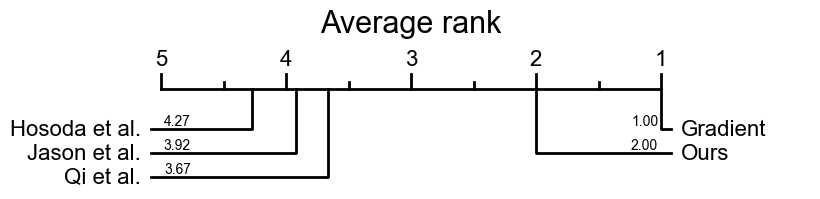

In [159]:
from helper import draw_cd_diag_for_selected_runs

# Slice df
df_focus = df_loaded.copy()
for key, value in focus_column_values.items():
    df_focus = df_focus[df_focus[key].isin(value)]

# 1. Combine group and hyperparam columns (excluding seed)
df_seeds_aggregated = (
    df_focus.groupby(GROUPPARAMS + HYPERPARAMS)
    .agg(
        median_task_acc=(
            "task_acc",
            "median",
        ),  # Median task_acc across seeds
        count=("seed", "count"),
    )
    .reset_index()
)
num_seeds = len(focus_column_values["seed"])
if not all(df_seeds_aggregated["count"].unique() == num_seeds):
    print(
        f"WARN: There are not {num_seeds} runs in each group, even though we "
        f"have {num_seeds} seeds selected. This is unexpected."
    )
    amount1 = sum(df_seeds_aggregated["count"] == 1)
    percentage1 = 100 * amount1 / len(df_seeds_aggregated)
    amount2 = sum(df_seeds_aggregated["count"] == 2)
    percentage2 = 100 * amount2 / len(df_seeds_aggregated)
    amountg3 = sum(df_seeds_aggregated["count"] > 3)
    percentageg3 = 100 * amountg3 / len(df_seeds_aggregated)
    print(f"Percentage of groups with 1 run: {percentage1:.2f}% ({amount1})")
    print(f"Percentage of groups with 2 runs: {percentage2:.2f}% ({amount2})")
    print(f"Percentage of groups with >3 runs: {percentageg3:.2f}% ({amountg3})")
ranked_data = []

# 2. Group by GROUPPARAMS for ranking
grouped = df_seeds_aggregated.groupby(GROUPPARAMS)
ranked_data = []

for group, group_df in grouped:
    group_df = group_df.copy()
    # Rank configurations within the group based on chosen (median) ranking metric
    #  (i.e., task_acc, time_elapsed)
    group_df["rank"] = group_df[f"median_{ranking_metric_column}"].rank(ascending=False)
    ranked_data.append(group_df)

# Combine all ranked data
ranked_df = pd.concat(ranked_data)

# 3.1 Compute the average rank, std, stderr, and average metric for each
#  unique configuration
aggregated = (
    ranked_df.groupby(HYPERPARAMS)
    .agg(
        avg_rank=("rank", "mean"),  # Average rank across groups
        std_rank=("rank", "std"),  # Standard deviation of ranks
        stderr_rank=(
            "rank",
            lambda x: np.std(x, ddof=1) / np.sqrt(len(x)),
        ),  # Standard error of ranks
        ##
        avg_task_acc=("median_task_acc", "mean"),  # Average task_acc across groups
        std_task_acc=("median_task_acc", "std"),  # Standard deviation of task_acc
        stderr_task_acc=(
            "median_task_acc",
            lambda x: np.std(x, ddof=1) / np.sqrt(len(x)),
        ),  # Standard error of task_acc
        count=("rank", "count"),  # Count of appearances in groups -> should be 48, right?!
    )
    .reset_index()
)

# Sort by average rank (ascending) to identify the best combinations
aggregated.sort_values(by="avg_rank", ascending=True, inplace=True)

# 3.2 Highlight the best combinations for the highlighter hyperparameters resp.
#  show only the special combinations (if highlighter is "special_combinations")
if highlighter == "special_combinations":
    highlight_combinations_keys = highlight_hyperparams[highlighter]
    # Can access the combinations via special_combinations[key] for key in
    #  highlight_combinations_keys
    # Group aggregated results by the hyperparameters that define special combinations
    keys = [
        "normalize_for_proxy_selection",
        "normalize_input_data",
        "normalize_weights",
        "proxy_method",
        "k",
        "aggregation_method",
        "aggregation_distance_function",
        "aggregation_weighting",
        "m",
    ]
    aggregated_groups = aggregated.groupby(keys, sort=False)
    # Clear it to fill it with special combinations
    aggregated = aggregated.iloc[:0]
    for key in highlight_combinations_keys:
        special_combination = special_combinations[key]
        # Check which group the special combination belongs to, i.e., find
        #  the first group that the combination falls into
        # Loop over all the group combinations
        fitting_group_key = None

        for group_key in aggregated_groups.groups.keys():
            if not isinstance(group_key, tuple):
                group_dict = {aggregated_groups.keys[0]: group_key}
            else:
                group_dict = dict(zip(keys, group_key))
            # Check if special combination matches this group
            if all(
                special_combination[param] == group_dict[param]
                for param in special_combination.keys()
            ):
                fitting_group_key = group_key
                break
        assert fitting_group_key is not None, print(
            f"Special combination {key} does not fit into any group."
        )
        # Get all runs within the group we identified and find matching combination
        group = aggregated_groups.get_group(fitting_group_key)
        found_special_combination = group.loc[
            (group[list(special_combination)] == pd.Series(special_combination)).all(axis=1)
        ]
        assert len(found_special_combination) > 0, f"Special combination {key} not found."
        # Take the best one with regards to avg rank
        found_special_combination = (
            pd.DataFrame(
                found_special_combination.loc[found_special_combination["avg_rank"].idxmin()]
            )
            .copy()
            .T
        )
        found_special_combination.loc[:, "WHAT?"] = key

        # Insert it into aggregated
        aggregated = pd.concat(
            [aggregated, found_special_combination.reset_index(drop=True)]
        ).reset_index(drop=True)
    highlight_combinations_keys = []  # because as keys, they are not useful later

elif highlighter is not False:
    highlight_combinations_keys = highlight_hyperparams[highlighter]
    # Find the best rows for the highlighted hyperparameters
    aggregated_groups = aggregated.groupby(highlight_combinations_keys, sort=False)

    best_combinations = aggregated_groups.first().reset_index()
    best_combinations["WHAT?"] = "BEST IN GROUP"

    # Concatenate the best combinations and baseline
    aggregated = best_combinations.reset_index(drop=True)

# 3.3 Pretty print "aggregated" to console, png, and tex code
vis_hyperparams = copy(HYPERPARAMS)

# Round "avg_rank", f"avg_{ranking_metric_column}" to 2 decimal places
aggregated["avg_rank"] = aggregated["avg_rank"].astype(float).round(2)
aggregated[f"avg_{ranking_metric_column}"] = (
    aggregated[f"avg_{ranking_metric_column}"].astype(float).round(2)
)

# Hide some columns
ignore_columns_in_table = [
    "presampling_fewshot_value",
]
if "mnn" not in focus_column_values["aggregation_method"]:
    ignore_columns_in_table.append("m")
for key in ignore_columns_in_table:
    vis_hyperparams.remove(key)

# Hide more in Tex table
ignore_columns_in_tex_table = ignore_columns_in_table + [
    "normalize_input_data",
    "normalize_for_proxy_selection",
    "normalize_layer_activations",
    "normalize_weights",
    "presampling_method",
    "presampling_quantile",
    "avg_rank",
]

# Hide rows
ignore_rows_in_table = ["MEDIAN IN GROUP", "OVERALL BEST"]
ignore_rows_in_tex_table = ignore_rows_in_table + []
# ignore_rows_in_cd_diag = ignore_rows_in_table + []

table = PrettyTable()
table.field_names = [
    "WHAT?",
    *highlight_combinations_keys,
    "-",  # Separator
    "Avg Rank",
    # "Rank Std",
    # "Rank Stderr",
    f"Avg {ranking_metric_column}",
    # f"{ranking_metric_column} Std",
    # f"{ranking_metric_column} Stderr",
    # f"Avg {metrics[0]}",
    # f"{metrics[0]} Std",
    # f"{metrics[0]} Stderr",
    # f"Avg {metrics[1]}",
    # f"{metrics[1]} Std",
    # f"{metrics[1]} Stderr",
    *[hp for hp in vis_hyperparams if hp not in highlight_combinations_keys],
    "Count",
]

for _, row in aggregated.iterrows():
    if row["WHAT?"] == "BEST IN GROUP":
        table.add_row(["-"] * len(table.field_names))
    if row["WHAT?"] == "OVERALL BEST" and "OVERALL BEST" in ignore_rows_in_table:
        continue
    table.add_row(
        [
            row["WHAT?"],
            *[row[param] for param in highlight_combinations_keys],
            "-",
            f"{row['avg_rank']:.2f}",
            # f"{row['std_rank']:.2f}",
            # f"{row['stderr_rank']:.2f}",
            f"{row[f'avg_{ranking_metric_column}']:.2f}",
            # f"{row[f'std_{ranking_metric_column}']:.2f}",
            # f"{row[f'stderr_{ranking_metric_column}']:.2f}",
            *[row[param] for param in vis_hyperparams if param not in highlight_combinations_keys],
            row["count"],
        ]
    )

print(
    f"Best HP combs across groups {GROUPPARAMS}, "
    f"highlighted along HPs {highlight_combinations_keys}:"
)
print(table)

# Save table to txt (pretty) and csv file
# with open(
#     os.path.join(
#         tables_save_dict,
#         f"{filename_prefix}_best_hps_{filename_highlighter_suffix}_{filename_metric_suffix}.txt",
#     ),
#     "w",
# ) as f:
#     f.write(str(table)

# aggregated.to_csv(
#     os.path.join(
#         tables_save_dict,
#         f"{filename_prefix}_best_hps_{filename_highlighter_suffix}_{filename_metric_suffix}.csv",
#     ),
#     index=False,
# )

# Also, save as image for "nice" (rather: ad hoc) share format
from PIL import Image, ImageDraw  # , ImageFont

im = Image.new("RGB", (3250, 100 + 20 * (len(aggregated) - 1)), "white")
draw = ImageDraw.Draw(im)
# font = ImageFont.truetype("FreeMono.ttf", 15)
draw.text((10, 10), str(table), fill="black")
# im.show()
# im.save(
#     os.path.join(
#         tables_save_dict,
#         f"{filename_prefix}_best_hps_{filename_highlighter_suffix}_{filename_metric_suffix}.png",
#     )
# )

# Also save as Tex file
col_slice = (
    ["WHAT?"]
    + highlight_combinations_keys
    + ["avg_rank", f"avg_{ranking_metric_column}", f"avg_{metrics[0]}", "count"]
    + [param for param in vis_hyperparams if param not in highlight_combinations_keys]
)
tex_table = aggregated[
    [
        col
        for col in col_slice
        if col in aggregated.columns and col not in ignore_columns_in_tex_table
    ]
]
tex_table = tex_table[~tex_table["WHAT?"].isin(ignore_rows_in_tex_table)]
# Adjust some column names for paper
tex_table = tex_table.rename(
    columns={
        "WHAT?": "Description",
        "num_proxies": "$k$",
        "avg_rank": "Avg. Rank",
        f"avg_{ranking_metric_column}": f"Avg. {ranking_metric_column}",
        f"avg_{metrics[0]}": f"Avg. {metrics[0]}",
        "count": "Count",
        "proxy_method": "Proxy Method",
        "aggregation_method": "\AGG",  # TODO: add l-number in here
    }
)
# Ignore them and convert to tex table
# tex_table.rename(columns=lambda x: x.replace("_", " ")).style.hide(axis="index").format(
#     precision=2
# ).to_latex(
#     os.path.join(
#         tables_save_dict,
#         f"{filename_prefix}_best_hps_{filename_highlighter_suffix}_{filename_metric_suffix}.tex",
#     ),
# )

# Get CD diagram for aggregated
metric = "median_task_acc"  # i.e., "Accuracy" will come from "median_task_acc"
draw_cd_diag_for_selected_runs(
    aggregated,
    df_seeds_aggregated,
    highlight_combinations_keys,
    metric,
    filename_prefix,
    f"{filename_highlighter_suffix}_{filename_metric_suffix}",
)

### Time Elapsed Comparions
Using `time_elapsed`.

In [180]:
from copy import copy
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

tables_save_dict = "result_tables"
os.makedirs(tables_save_dict, exist_ok=True)

### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        "resnet50",
        "vit_b_16",
        "swin_b",
        # "convnextv2-femto-1k-224",
    ],
    "dataset_name": [
        # "ImageNet",
        "MNIST",
        "FashionMNIST",
        "CIFAR-10",
    ],
    "seed": [17121997, 123987, 12412312],
    "task_name": [
        "all",
        "even",
        "odd",
        "short",
    ],
    # + [generate_task_desc([str(el) for el in rt[0]]) for rt in RANDOM_TASKS],
    "presampling_fewshot_value": [
        -1,
        # 1,
        # 2,
        # 5,
        # 10,
        # 20,
    ],
}
methods_to_compare = [  # listed in format
    # (proxy_method,k,aggregation_method,aggregation_function,aggregation_weighting,m,normalize_for_proxy_selection,normalize_weights,normalize_input_data)
    ("mean", 1, "max", "inner_product", "uniform", -1,  "l2", "l2", "l2"), #
    ("kmeans", 5, "max", "inner_product", "uniform", -1, "l2", "l2", "l2"), #
    ("kmeans", 20, "max",  "inner_product", "uniform", -1, "l2", "l2", "l2"), #
    ("kls", 1, "max", "inner_product", "uniform", -1,  "none", "none", "none"), #
	("kls", 20, "max", "inner_product", "uniform", -1, "none", "none", "none"), #
    ("kls", 5, "max", "inner_product", "uniform", -1, "none", "none", "none"), #
]

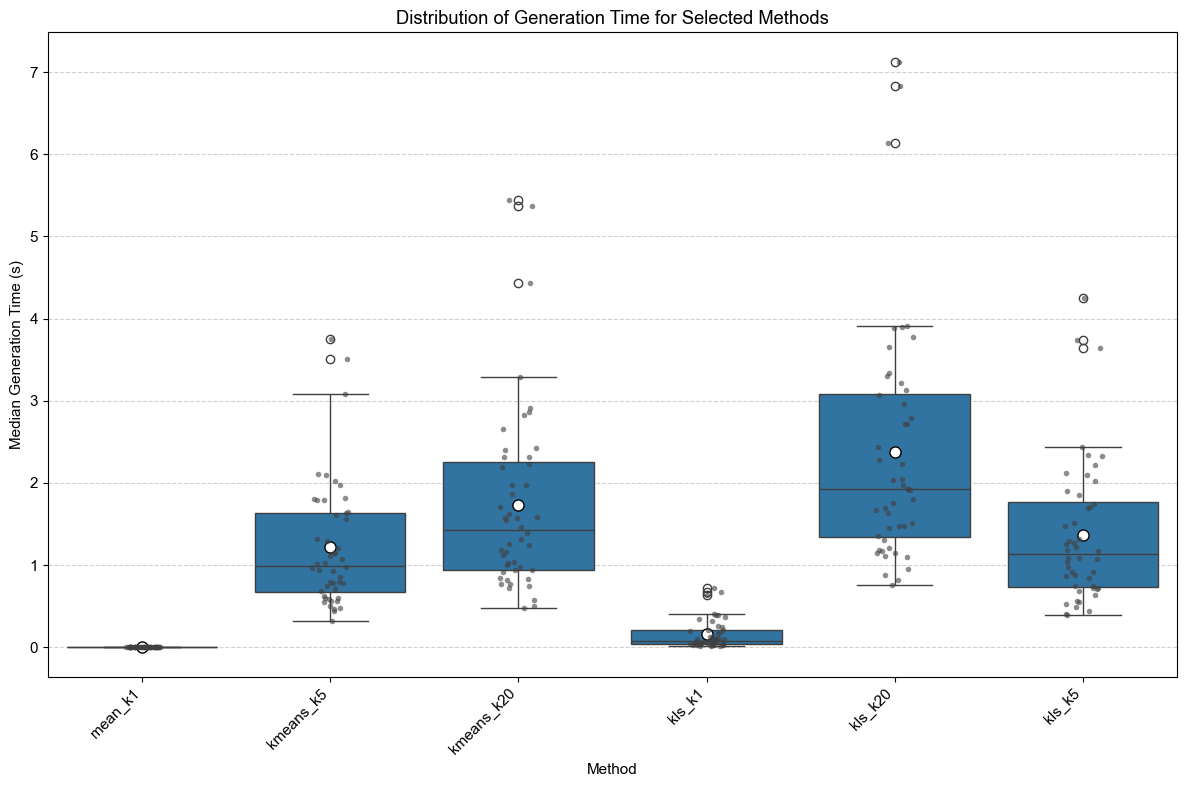

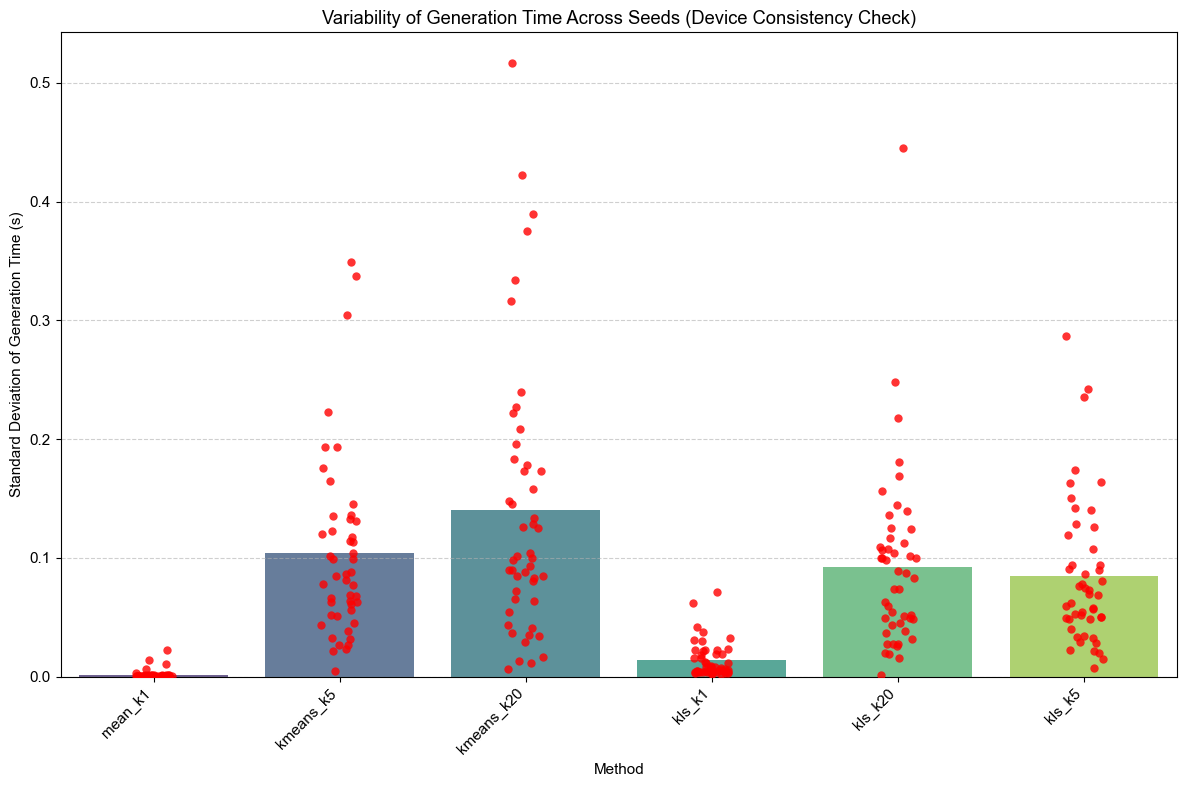

Summary statistics for standard deviation across methods:
                mean  median     min     max  count
method_label                                       
mean_k1       0.0017  0.0005  0.0001  0.0219     48
kmeans_k5     0.1044  0.0853  0.0051  0.3491     48
kmeans_k20    0.1404  0.1006  0.0067  0.5167     48
kls_k1        0.0142  0.0079  0.0025  0.0709     48
kls_k20       0.0924  0.0852  0.0017  0.4455     48
kls_k5        0.0850  0.0693  0.0075  0.2864     48

Summary statistics for median generation time across methods:
                mean  median     min     max  count
method_label                                       
mean_k1       0.0029  0.0021  0.0010  0.0094     48
kmeans_k5     1.2249  0.9933  0.3172  3.7475     48
kmeans_k20    1.7321  1.4289  0.4789  5.4469     48
kls_k1        0.1593  0.0823  0.0163  0.7242     48
kls_k20       2.3717  1.9259  0.7554  7.1264     48
kls_k5        1.3724  1.1312  0.3935  4.2497     48


In [184]:
df_focus = df_loaded.copy()

# Remove "task_acc", "task_train_acc", "created_at", and "origin" columns, because we focus
#  on "total_GEN_time" here
df_focus = df_focus.drop(
    ["task_acc", "task_train_acc", "time_elapsed", "created_at", "origin"], axis=1, errors="ignore"
)

# Slice df
for key, value in focus_column_values.items():
    df_focus = df_focus[df_focus[key].isin(value)]

# 1. Group by excluding seed
df_seeds_aggregated = (
    df_focus.groupby(df_focus.columns.difference(["seed", "total_GEN_time"]).tolist())
    .agg(
        median_gen_time=("total_GEN_time", "median"),
        std_gen_time=("total_GEN_time", "std"),
        count=("seed", "count"),
    )
    .reset_index()
)

# Filter for the methods to compare
hyperparam_cols = [
    "proxy_method",
    "k",
    "aggregation_method",
    "aggregation_distance_function",
    "aggregation_weighting",
    "m",
    "normalize_for_proxy_selection",
    "normalize_weights",
    "normalize_input_data",
]

df_compare_list = []
for method_params in methods_to_compare:
    condition = pd.Series(True, index=df_seeds_aggregated.index)
    for col, val in zip(hyperparam_cols, method_params):
        condition &= df_seeds_aggregated[col] == val
    df_compare_list.append(df_seeds_aggregated[condition])

df_to_plot = pd.concat(df_compare_list)

# Create a method label for plotting
df_to_plot["method_label"] = df_to_plot.apply(
    lambda row: f"{row['proxy_method']}_k{row['k']}", axis=1
)

# Create improved plot showing distribution of time elapsed with boxplot + stripplot
fig, ax = plt.subplots(figsize=(12, 8))

# Boxplot to show distribution summary, including the mean
sns.boxplot(
    x="method_label",
    y="median_gen_time",
    data=df_to_plot,
    ax=ax,
    showmeans=True,
    meanprops={
        "marker": "o",
        "markerfacecolor": "white",
        "markeredgecolor": "black",
        "markersize": "8",
    },
)

# Overlay a stripplot to show individual data points
sns.stripplot(
    x="method_label",
    y="median_gen_time",
    data=df_to_plot,
    jitter=True,
    alpha=0.6,
    ax=ax,
    color=".25",
    size=4,
)

ax.set_xlabel("Method")
ax.set_ylabel("Median Generation Time (s)")
ax.set_title("Distribution of Generation Time for Selected Methods")
ax.grid(True, linestyle="--", alpha=0.6, axis="y")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Second plot: Show standard deviation across seeds to assess device consistency
fig, ax = plt.subplots(figsize=(12, 8))

# Bar plot for standard deviation
sns.barplot(
    x="method_label",
    y="std_gen_time",
    data=df_to_plot,
    ax=ax,
    ci=None,  # Don't show confidence intervals since we're showing std itself
    palette="viridis",
    alpha=0.8,
)

# Add individual points to show the actual std values
sns.stripplot(
    x="method_label",
    y="std_gen_time",
    data=df_to_plot,
    jitter=True,
    alpha=0.8,
    ax=ax,
    color="red",
    size=6,
)

ax.set_xlabel("Method")
ax.set_ylabel("Standard Deviation of Generation Time (s)")
ax.set_title("Variability of Generation Time Across Seeds (Device Consistency Check)")
ax.grid(True, linestyle="--", alpha=0.6, axis="y")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

from pandas.api.types import CategoricalDtype

# Define desired order
order = df_to_plot["method_label"].unique()

# Convert to categorical to preserve that order
df_to_plot["method_label"] = df_to_plot["method_label"].astype(
    CategoricalDtype(categories=order, ordered=True)
)

# Now groupby keeps the order
summary_stats = (
    df_to_plot.groupby("method_label", observed=True)["std_gen_time"]
    .agg(["mean", "median", "min", "max", "count"])
    .round(4)
)

time_stats = (
    df_to_plot.groupby("method_label", observed=True)["median_gen_time"]
    .agg(["mean", "median", "min", "max", "count"])
    .round(4)
)

print("Summary statistics for standard deviation across methods:")
print(summary_stats)

print("\nSummary statistics for median generation time across methods:")
print(time_stats)

### Line chart for accuracy over number of proxies k (Figure 6)

In [5]:
graphs_save_dict = "result_graphs"
os.makedirs(graphs_save_dict, exist_ok=True)


### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        # "resnet50",
        # "vit_b_16",
        # "swin_b",
        # "convnextv2-femto-1k-224",
    ],
    "dataset_name": [
        # "ImageNet",
        # "MNIST",
        # "FashionMNIST",
        "CIFAR-10",
    ],
    "seed": [17121997, 123987, 12412312],
    "task_name": [
        "all",
        # "even",
        # "odd",
        # "short",
    ],
    # + [generate_task_desc([str(el) for el in rt[0]]) for rt in RANDOM_TASKS],
    "presampling_fewshot_value": [
        -1,
        # 1,
        # 2,
        # 5,
        # 10,
        # 20,
    ],
    "proxy_method": [
        "kmeans",
        "kmedoids",
        "mean",
        # "ls",
        "cov_max",
        "random",
        "fps",
        "all",
    ],
    "k": [
        -1,
        1,
        2,
        3,
        5,
        10,
        20,
        50,
        100,
    ],
    "aggregation_method": [
        "max",
    ],
    "m": [
        -1,
    ],
    "normalize_for_proxy_selection": [  # NORM_pre for generating weights
        "l2",
    ],
    "normalize_weights": [  # NORM_post for generated weights
        "l2",
    ],
    "normalize_input_data": [  # NORM_inf, that is, normalization of input embeddings in inference
        "l2",
    ],
}

focus_column_values_abbrevs = {
    "bb": "res",
    "ds": "cif",
    "task": "long",
    "map": "none",
    "pres_few": "all",  # "little", "all"
    "proxy": "standard",  # "mean,lmean",  # "standard",  # "standard",  # ="all,random,mean,n2mean,kmeans,kmed,agg,fps,cov",
    "num_proxies": "large",  # "all",  # "large",  # "verysmall",  # "many", "small"
    "agg": "max",  # "mean,max,knn",
}

plotting_metric_column = "task_acc"  # "task_acc" , "time", # TODO: task_f1_weighted_avg
filename_prefix = f"slice_{'_&_'.join(f'{k}_{v}' for k,v in focus_column_values_abbrevs.items())}"

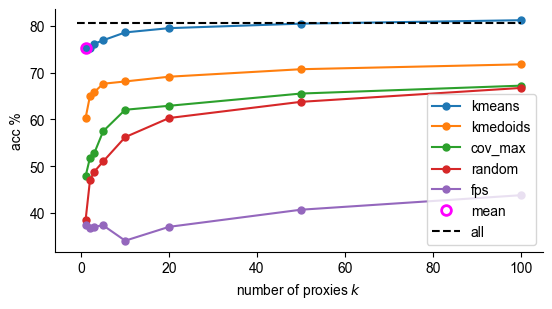

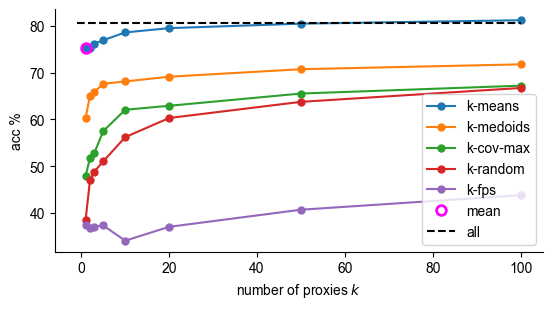

In [7]:
%matplotlib inline
from copy import copy
import os
import pandas as pd
import matplotlib.pyplot as plt
from helper import GROUPPARAMS, HYPERPARAMS

df_focus = df_loaded.copy()
for key, value in focus_column_values.items():
	df_focus = df_focus[df_focus[key].isin(value)]

df_focus = (
	df_focus
	.groupby(GROUPPARAMS + HYPERPARAMS)
	.agg(
		avg_task_acc=("task_acc", "median"),
		count=("seed", "count"),
	)
	.reset_index()
)
df_focus.sort_values(GROUPPARAMS, inplace=True)

backbones     = df_focus["backbone_name"].unique()
datasets      = df_focus["dataset_name"].unique()
mapping_names = df_focus["mapping_name"].unique()
task_names    = df_focus["task_name"].unique()

method_renamer = {
	"mean": "mean",
	"ls": "least-squares",
	"kmeans": "k-means",
	"kmedoids": "k-medoids",
	"cov_max": "k-cov-max",
	"kls": "k-least-squares",
	"random": "k-random",
	"fps": "k-fps",
}

nrows = len(backbones)
ncols = len(datasets) * len(mapping_names) * len(task_names)
aspect_ratio = 2 / 4
fig_height   = text_width_inches * aspect_ratio

if nrows > 1 or ncols > 1:
	fig, axes = plt.subplots(
		nrows=nrows,
		ncols=ncols,
		figsize=(3 * text_width_inches, 3 * fig_height),
		sharex=True,
		sharey=True
	)
else:
	fig  = plt.figure(figsize=(text_width_inches, fig_height))
	axes = [[fig.add_subplot(1, 1, 1)]]

for i, backbone_name in enumerate(backbones):
	per_row_counter = 0
	for dataset_name in datasets:
		for task_name in task_names:
			for mapping_name in mapping_names:
				ax = axes[i][per_row_counter]
				per_row_counter += 1

				sliced = df_focus[
					(df_focus["backbone_name"] == backbone_name) &
					(df_focus["dataset_name"]  == dataset_name)  &
					(df_focus["task_name"]     == task_name)     &
					(df_focus["mapping_name"]  == mapping_name)
				]

				df_vis = []
				for proxy_method in focus_column_values["proxy_method"]:
					proxy_df = sliced[sliced["proxy_method"] == proxy_method].copy()
					proxy_df["key"] = proxy_method
					df_vis.append(proxy_df)
				# for key, combination in special_combinations.items():
				#     special_df = sliced[
				#         (sliced[list(combination)] == pd.Series(combination)).all(axis=1)
				#     ].copy()
				#     special_df["key"] = key
				#     df_vis.append(special_df)
				df_vis = pd.concat(df_vis, ignore_index=True)

				df_vis_piv = df_vis.pivot(index="k", columns="key", values="avg_task_acc")
				df_vis_piv.ffill(inplace=True)
				df_vis_piv = df_vis_piv[df_vis_piv.index <= 100]

				df_vis_piv_not_all = df_vis_piv.drop(columns=["all"], errors="ignore")
				df_vis_piv_not_all = df_vis_piv_not_all.loc[df_vis_piv_not_all.index != -1]
				if "mean" in df_vis_piv_not_all.columns:
					df_vis_piv_not_all = df_vis_piv_not_all.drop(columns=["mean"])
				if "ls" in df_vis_piv_not_all.columns:
					df_vis_piv_not_all = df_vis_piv_not_all.drop(columns=["ls"])
				order = df_vis_piv_not_all.loc[5].sort_values(ascending=False).index.tolist()
				df_vis_piv_not_all = df_vis_piv_not_all[order]

				styles = ['-o'] * df_vis_piv_not_all.shape[1]

				# Rename methods
				df_vis_piv_not_all.rename(columns=method_renamer, inplace=True)
				df_vis_piv_not_all.plot(ax=ax, style=styles, linewidth=1.5, markersize=5, legend=False)

				if 1 in df_vis_piv.index and "mean" in df_vis_piv.columns:
					mean_val = df_vis_piv.at[1, "mean"]
					ax.plot(1, mean_val,
							linestyle="None",
							marker="o",
							markersize=7,
							markerfacecolor="none",      # make center transparent
							markeredgecolor="magenta",
							markeredgewidth=2,
							label="mean")
				if 1 in df_vis_piv.index and "ls" in df_vis_piv.columns:
					ls_val = df_vis_piv.at[1, "ls"]
					ax.plot(1, ls_val,
							linestyle="None",
							marker="o",
							markersize=7,
							markerfacecolor="none",      # make center transparent
							markeredgecolor="blue",
							markeredgewidth=2,
							label="least-squares")

				df_vis_piv["all"].plot(ax=ax, linestyle="--", linewidth=1.5, color="black", label="all")

				ax.legend(loc="lower right")
				ax.set_xlabel(r"number of proxies $k$")
				if i == 0:
					ax.set_ylabel("acc %")
				# ax.set_title(f"{backbone_name}, {dataset_name}, {task_name}, {mapping_name}")
				ax.spines['top'].set_visible(False)
				ax.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.5, wspace=0.3)
plt.savefig(os.path.join(graphs_save_dict, f"{filename_prefix}_k_vs_avg_acc.pdf"), bbox_inches="tight", dpi=300)
plt.show()

### Few-Shot line plot (Figure 10) ("Low-Data Regime")

In [15]:
graphs_save_dict = "result_graphs"
os.makedirs(graphs_save_dict, exist_ok=True)
%matplotlib inline


### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        "resnet50",
        "vit_b_16",
        "swin_b",
    ],
    "dataset_name": [
        "MNIST",
        "FashionMNIST",
        "CIFAR-10",
    ],
    "seed": [14057, 994348, 23092007, 123456, 98765],
    "task_name": [
        "all",
    ],
    "presampling_fewshot_value": [
        # -1,
        # 1,
        # 2,
        # 5,
        10,
        20,
        50,
        100,
        200,
        400,
        # 600,
        # 800,
        # 1000,
    ],
    "proxy_method": [
        "kmeans",
        # "kls",
        # "all",
    ],
    "k": [
        -1,
        1,
        5,
        20,
    ],
    "aggregation_method": [
        "max",
    ],
    "m": [
        -1,
    ],
    "normalize_for_proxy_selection": [  # NORM_pre for generating weights
        "l2",
        # "none",
    ],
    "normalize_weights": [  # NORM_post for generated weights
        "l2",
        # "none",
    ],
    "normalize_input_data": [  # NORM_inf, that is, normalization of input embeddings in inference
        "l2",
        # "none",
    ],
}

focus_column_values_abbrevs = {
    "bb": "all",
    "ds": "all",
    "task": "long",
    "map": "none",
    "pres_few": "all",  # "little", "all"
    "proxy": "kmeans",  # "mean,lmean",  # "standard",  # "standard",  # ="all,random,mean,n2mean,kmeans,kmed,agg,fps,cov",
    "num_proxies": "standard",  # "all",  # "large",  # "verysmall",  # "many", "small"
    "agg": "max",  # "mean,max,knn",
}

plotting_metric_column = "task_acc"
filename_prefix = f"slice_{'_&_'.join(f'{k}_{v}' for k,v in focus_column_values_abbrevs.items())}"

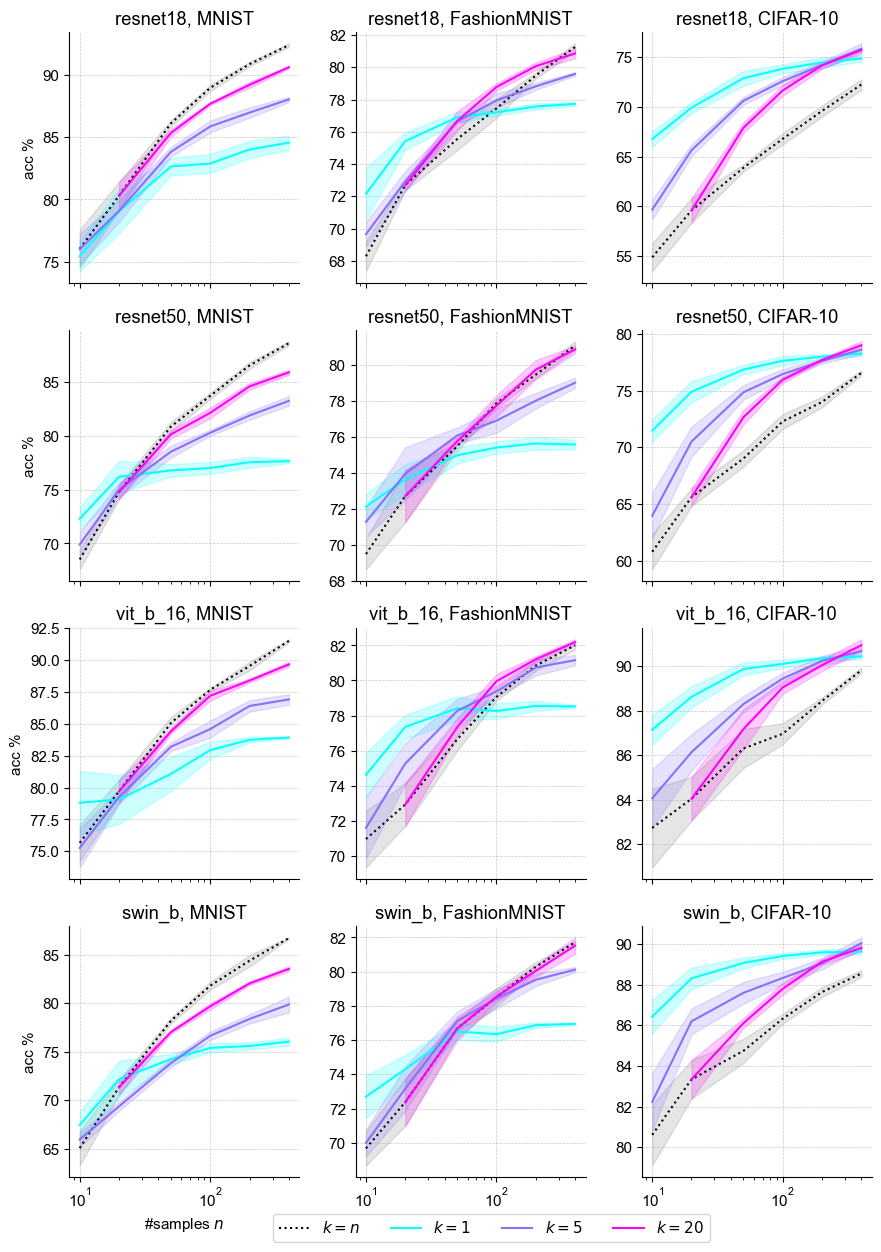

In [16]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import GROUPPARAMS, HYPERPARAMS

# filter and aggregate
df_focus = df_loaded.copy()
for key, vals in focus_column_values.items():
    df_focus = df_focus[df_focus[key].isin(vals)]

df_focus = (
    df_focus
    .groupby(GROUPPARAMS + HYPERPARAMS)
    .agg(
        mean_task_acc=("task_acc", "median"),
        std=("task_acc", "std"),
        count=("seed", "count"),
    )
    .reset_index()
)
df_focus.sort_values(GROUPPARAMS, inplace=True)
df_focus["lower_ci"] = df_focus["mean_task_acc"] - 1.96 * (df_focus["std"] / np.sqrt(df_focus["count"]))
df_focus["upper_ci"] = df_focus["mean_task_acc"] + 1.96 * (df_focus["std"] / np.sqrt(df_focus["count"]))

backbones   = df_focus["backbone_name"].unique()
# Apply a custom sorting (note not all might be present): resnet18, resnet50, vit_b_16, swin_b
backbones = sorted(backbones, key=lambda x: (x != "resnet18", x != "resnet50", x != "vit_b_16", x != "swin_b"))
datasets    = df_focus["dataset_name"].unique()
# Sort like MNIST, FashionMNIST, CIFAR-10 (if existing)
datasets = sorted(datasets, key=lambda x: (x != "MNIST", x != "FashionMNIST", x != "CIFAR-10"))
mapping     = "kmeans" ## "kls"
task        = "all"
k_vals      = sorted([k for k in df_focus["k"].unique() if k <= focus_column_values["presampling_fewshot_value"][-1]])
colors = {
    -1: "black",
     1: np.array([9,255,255]) / 255,
     5: np.array([137,111,251]) / 255,
    20: np.array([255,0,250])   / 255,
}
linestyles  = { -1: ":", 1: "-", 5: "-", 20: "-" }

nrows, ncols = len(backbones), len(datasets)
aspect_ratio = 3 / 4
fig_height   = text_width_inches * aspect_ratio
plt.rcParams.update({"font.size": 11})  # Adjust size as needed
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
	figsize=(1.4*text_width_inches, 2.8*fig_height), # 1.4 # 2.8
    sharex=True,
    sharey=False
)

# ensure axes is 2D array
if nrows == 1 and ncols == 1:
    axes = np.array([[axes]])
elif nrows == 1:
    axes = np.array([axes])
elif ncols == 1:
    axes = np.array([[ax] for ax in axes])

for i, bb in enumerate(backbones):
    for j, ds in enumerate(datasets):
        ax = axes[i, j]
        for k in k_vals:
            subset = df_focus[
                (df_focus["backbone_name"] == bb) &
                (df_focus["dataset_name"]  == ds) &
                (df_focus["proxy_method"]  == mapping) &
                (df_focus["task_name"]     == task) &
                (df_focus["k"]             == k)
            ].copy()
            if subset.empty:
                continue
            # Replace -1 fewshot_value by 6000
            subset["presampling_fewshot_value"] = subset["presampling_fewshot_value"].replace(-1, 6000)
            if k != -1:
                subset = subset[subset["k"] <= subset["presampling_fewshot_value"]]
            if subset.empty:
                continue

			# Sort by presampling fewshot_value
            subset = subset.sort_values("presampling_fewshot_value")

            ax.plot(
                subset["presampling_fewshot_value"],
                subset["mean_task_acc"],
                linestyle=linestyles[k],
                color=colors[k],
                label=r"$k=n$" if k == -1 else rf"$k={k}$"
            )
            alpha = 0.2 if k != -1 else 0.1
            ax.fill_between(
                subset["presampling_fewshot_value"],
                subset["lower_ci"],
                subset["upper_ci"],
                color=colors[k],
                alpha=alpha,
            )

        ax.set_xscale("log")
        ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
        ax.set_title(rf"{bb}, {ds}")
        if i == nrows - 1 and j==0:
            ax.set_xlabel(r"#samples $n$")
        if j == 0:
            ax.set_ylabel("acc %")
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles, labels, loc="lower center", ncol=len(k_vals),
           bbox_to_anchor=(0.55, 0.05),
           )
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(
    os.path.join(graphs_save_dict, f"k_vs_n_logscale_Qi_upto400.pdf"), # k_vs_n_logscale_Qi
    bbox_inches="tight",
    dpi=300
)
plt.show()

### Load NC data

In [4]:
# Get NC results from nc_results/imagenet_nc1_results.csv and standard_nc1_results.csv
nc1_results = pd.read_csv(os.path.join("nc_results", "imagenet_nc1_results.csv"))
# Concat other results
standard_nc1_results = pd.read_csv(os.path.join("nc_results", "standard_nc1_results.csv"))
nc1_results = pd.concat([nc1_results, standard_nc1_results], ignore_index=True)
nc1_results

,dataset,backbone,remapping,n_classes_per_label,remapping_index,nc_1,vci,intra_trace,inter_trace,intra_rank,inter_rank
0,ImageNet,resnet18,1_in_1-0,1.0,0.0,0.249113,0.047157,0.869763,0.130237,340,9
1,ImageNet,resnet18,1_in_1-1,1.0,1.0,0.549280,0.071842,0.862129,0.137871,332,9
2,ImageNet,resnet18,1_in_1-2,1.0,2.0,0.531872,0.060302,0.854838,0.145162,339,9
3,ImageNet,resnet18,1_in_1-3,1.0,3.0,0.231757,0.040801,0.849845,0.150155,336,9
4,ImageNet,resnet18,1_in_1-4,1.0,4.0,0.359873,0.056763,0.847758,0.152242,329,9
...,...,...,...,...,...,...,...,...,...,...,...
411,MNIST&MNIST-M&USPS&SVHN,vit_b_16,NaN,NaN,NaN,10.668107,0.576874,0.977701,0.022314,657,9
412,MNIST,swin_b,NaN,NaN,NaN,7.510301,0.297314,0.930504,0.066892,89,9
413,FashionMNIST,swin_b,NaN,NaN,NaN,2.043176,0.271658,0.827813,0.172187,300,9
414,CIFAR10,swin_b,NaN,NaN,NaN,0.431034,0.187334,0.820062,0.179938,683,9


In [5]:
# load data
nc1_results = pd.read_csv(os.path.join("nc_results", "imagenet_nc1_results.csv"))
standard_nc1 = pd.read_csv(os.path.join("nc_results", "standard_nc1_results.csv"))
nc1_results = pd.concat([nc1_results, standard_nc1], ignore_index=True)

results_all = nc1_results[nc1_results["dataset"] == "ImageNet"]
other = nc1_results[nc1_results["dataset"] != "ImageNet"]

# Rename CIFAR10 to CIFAR-10
other["dataset"] = other["dataset"].replace("CIFAR10", "CIFAR-10")
# Rename MNIST&MNIST-M&USPS&SVHN to CombiDigits
other["dataset"] = other["dataset"].replace("MNIST&MNIST-M&USPS&SVHN", "CombiDigits")

/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_35524/1159053657.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other["dataset"] = other["dataset"].replace("CIFAR10", "CIFAR-10")
/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_35524/1159053657.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  other["dataset"] = other["dataset"].replace("MNIST&MNIST-M&USPS&SVHN", "CombiDigits")


### NC Line and Dot Plots (Figure 11a)

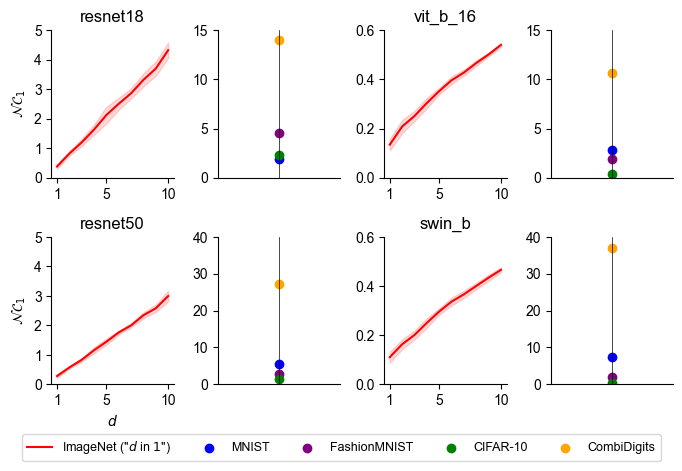

In [90]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

backbone = ["resnet18", "vit_b_16", "resnet50", "swin_b"]
aspect_ratio = 3 / 4
fig_height = text_width_inches * aspect_ratio

plt.rcParams.update({"font.size": 10})  # Adjust size as needed
fig, ax = plt.subplots(
    2,
    4,
    figsize=(1.1 * text_width_inches, fig_height),
)
count_lm = -1
count_d = -1

for i in range(2):
    for j in range(4):
        if j % 2 == 0:  # ImageNet
            count_lm += 1
            bb = backbone[count_lm]
            df_bb = results_all[results_all["backbone"] == bb]
            d_vals = np.sort(df_bb["n_classes_per_label"].dropna().unique())

            mean_values = []
            ci_lower = []
            ci_upper = []
            for d in d_vals:
                arr = df_bb[df_bb["n_classes_per_label"] == d]["nc_1"]
                m = arr.mean()
                std = arr.std()
                n = arr.count()
                mean_values.append(m)
                ci_lower.append(m - 1.96 * (std / np.sqrt(n)))
                ci_upper.append(m + 1.96 * (std / np.sqrt(n)))

            ax[i, j].plot(d_vals, mean_values, "-", color="red", label=r'ImageNet ("$d$ in $1$")')
            ax[i, j].fill_between(d_vals, ci_lower, ci_upper, color="red", alpha=0.15)
            ax[i, j].spines["right"].set_visible(False)
            ax[i, j].spines["top"].set_visible(False)
            ax[i, j].set_title(bb)
            ax[i, j].set_xticks(d_vals)

            if bb in ["resnet18", "resnet50"]:
                ax[i, j].set_ylabel(r"$\mathcal{NC}_1$")
            if bb in ["resnet50",]: # "swin_b"]:
                ax[i, j].set_xlabel("$d$")

            # y-axis scaling
            if bb in ["resnet18", "resnet50"]:
                ax[i, j].set_ylim(0, 5)
            elif bb in ["vit_b_16", "swin_b"]:
                ax[i, j].set_ylim(0, 0.6)

            # adjust x-ticks
            ax[i, j].set_xticks([1, 5, 10])
            ax[i, j].set_xticklabels(["1", "5", "10"])

        else:  # Other datasets
            count_d += 1
            bb = backbone[count_d]
            df_bb = results_all[results_all["backbone"] == bb]
            other_bb = other[other["backbone"] == bb]

            d_max = np.max(df_bb["n_classes_per_label"].dropna())
            ax[i, j].axvline(d_max, color="black", linewidth=0.5)

            colors = ["blue", "purple", "green", "orange"]
            datasets = ["MNIST", "FashionMNIST", "CIFAR-10", "CombiDigits"]
            for k, ds in enumerate(datasets):
                y = other_bb[other_bb["dataset"] == ds]["nc_1"].values
                if y.size:
                    ax[i, j].scatter(d_max, y[0], color=colors[k], label=ds)

            ax[i, j].spines["right"].set_visible(False)
            ax[i, j].spines["top"].set_visible(False)
            ax[i, j].set_xticks([])

            # y-axis scaling
            if bb in ["resnet18", "vit_b_16"]:
                ax[i, j].set_ylim(0, 15)
            elif bb in ["resnet50", "swin_b"]:
                ax[i, j].set_ylim(0, 40)

h1, l1 = ax[0, 0].get_legend_handles_labels()  # the ImageNet line
h2, l2 = ax[1, 1].get_legend_handles_labels()  # the MNIST/Fashion/CIFAR/CombiDigits dots
fig.legend(h1 + h2, l1 + l2, loc="lower center", ncol=5, bbox_to_anchor=(0.5, 0), fontsize=9)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(os.path.join(graphs_save_dict, f"nc1_OLD.pdf"), bbox_inches="tight", dpi=300)
plt.show()

/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_44286/1705811020.py:128: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


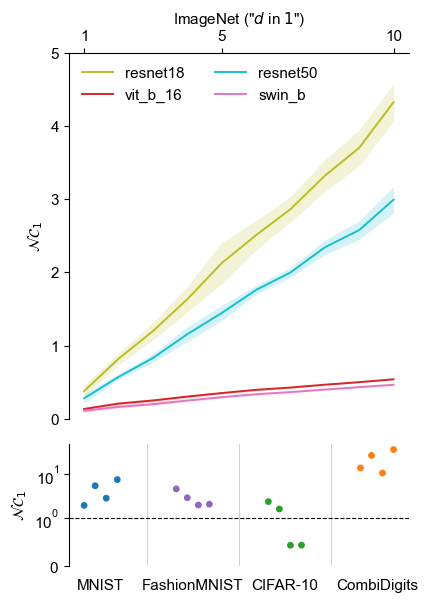

In [ ]:
## UPDATED VERSION FOR TMLR; highlighting more clearly NC1>1

# --- Config
backbones = ["resnet18", "resnet50", "vit_b_16", "swin_b"]
datasets = ["MNIST", "FashionMNIST", "CIFAR-10", "CombiDigits"]

# Horizontal jitter per backbone for the bottom subplot so points don’t overlap
jitter_map = {
    "resnet18": -0.18,
    "resnet50": -0.06,
    "vit_b_16": 0.06,
    "swin_b": 0.18,
}

# Figure geometry
aspect_ratio = 3 / 4
fig_h = text_width_inches * aspect_ratio
plt.rcParams.update({"font.size": 11})

fig, (ax_top, ax_bot) = plt.subplots(
    2,
    1,
    figsize=(0.7 * text_width_inches, 1.3 * fig_h),
    gridspec_kw={"height_ratios": [3, 1]},
    constrained_layout=True,
)

metric = "nc_1"  # vci

# ---------------------------
# Top subplot: ImageNet ("d in 1") with 4 backbones + CI bands
# ---------------------------
for bb in backbones:
    df_bb = results_all[results_all["backbone"] == bb]
    d_vals = np.sort(df_bb["n_classes_per_label"].dropna().unique())
    means, lo, hi = [], [], []
    for d in d_vals:
        arr = df_bb.loc[df_bb["n_classes_per_label"] == d, metric].dropna().values
        if arr.size == 0:
            means.append(np.nan)
            lo.append(np.nan)
            hi.append(np.nan)
            continue
        m = float(np.mean(arr))
        s = float(np.std(arr, ddof=1)) if arr.size > 1 else 0.0
        n = arr.size
        sem95 = 1.96 * (s / np.sqrt(n)) if n > 0 else np.nan
        means.append(m)
        lo.append(m - sem95)
        hi.append(m + sem95)

    c = backbone_colors[bb]
    ax_top.plot(d_vals, means, "-", color=c, linewidth=1.4, label=bb)
    ax_top.fill_between(d_vals, lo, hi, color=c, alpha=0.18, linewidth=0)

# Cosmetics
# ax_top.set_title('ImageNet ("$d$ in $1$")')
ax_top.set_xlabel('ImageNet ("$d$ in $1$")')
ax_top.set_ylabel(r"$\mathcal{NC}_1$")  # "VCI"
ax_top.set_xticks([1, 5, 10])
ax_top.set_xticklabels(["1", "5", "10"])
# Respect your paper’s ranges
ax_top.set_ylim(0, 5)  # 1)
ax_top.xaxis.set_ticks_position("top")
ax_top.xaxis.set_label_position("top")
ax_top.spines["top"].set_visible(True)
ax_top.spines["right"].set_visible(False)
ax_top.spines["bottom"].set_visible(False)
# ax_top.axhline(1.0, color="black", linestyle="--", linewidth=0.8)
handles, labels = ax_top.get_legend_handles_labels()
order = [0, 2, 1, 3]
handles = [handles[idx] for idx in order]
labels = [labels[idx] for idx in order]

leg_top = ax_top.legend(
    handles,
    labels,
    ncol=2,
    loc="upper left",
    # bbox_to_anchor=(0.5, 0),
    frameon=False,
)  # title="Backbone",

# ---------------------------
# Bottom subplot: tight 1D strips per dataset, only y-axis shown
# Each dataset occupies a narrow x slot; within it, one point per backbone, colored by dataset,
# slightly jittered by backbone (horizontal) to avoid overlap.
# Legend here is for datasets.
# ---------------------------
x_positions = {ds: i for i, ds in enumerate(datasets)}
for ds in datasets:
    for bb in backbones:
        row = other[(other["dataset"] == ds) & (other["backbone"] == bb)]
        if row.shape[0] == 0:
            continue
        y = float(row[metric].iloc[0])
        x = x_positions[ds] + jitter_map[bb]
        ax_bot.scatter(x, y, s=24, color=dataset_colors[ds], edgecolor="none")

# Vertical separators to suggest “tight 1D plots next to each other”
for i in range(len(datasets) - 1):
    ax_bot.axvline(i + 0.5, color="black", linewidth=0.5, alpha=0.25)

# Cosmetics: only y-axis
ax_bot.set_yscale("symlog", linthresh=1)
ax_bot.set_ylabel(r"$\mathcal{NC}_1$")  # "VCI"
ax_bot.set_ylim(
    0, 50  # 1
)  # matches your prior "other" scaling upper bound across models; adjust if needed
ax_bot.spines["top"].set_visible(False)
ax_bot.spines["right"].set_visible(False)
ax_bot.spines["bottom"].set_visible(False)
ax_bot.axhline(1.0, color="black", linestyle="--", linewidth=0.8)
ax_bot.set_xticks([])  # no x-axis ticks
ax_bot.set_xlabel("")  # no x label
# Annotate dataset labels compactly under each strip
for ds, xpos in x_positions.items():
    ax_bot.text(
        xpos,
        ax_bot.get_ylim()[0] - 0.005 * (ax_bot.get_ylim()[1] - ax_bot.get_ylim()[0]),
        ds,
        ha="center",
        va="top",
        fontsize=11,
    )

# Making tighter layout
fig.tight_layout()

plt.savefig(os.path.join(graphs_save_dict, f"nc1.pdf"), bbox_inches="tight", dpi=300)

### NC and Num Proxies (Figure 11b)

In [ ]:
graphs_save_dict = "result_graphs"
os.makedirs(graphs_save_dict, exist_ok=True)

### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        "resnet50",
        "swin_b",
        "vit_b_16",
    ],
    "dataset_name": [
        "ImageNet",
        "MNIST",
        "FashionMNIST",
        "CIFAR-10",
        "CombiDigits",
    ],
    "seed": [17121997, 123987, 12412312],
    "mapping_name": [
        "none",
        "combined",
        # map1-0, ..., map1-9, map2-0, ..., map2-9, ..., map10-0, ..., map10-9
        *[f"map{i}-{j}" for i in range(1, 11) for j in range(10)],
    ],
    "task_name": [
        "all",
    ],
    "presampling_fewshot_value": [
        -1,
    ],
    "proxy_method": [
        "kmeans",
        # "kls",
    ],
    "k": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "aggregation_method": [
        "max",
    ],
    "aggregation_distance_function": [
        "inner_product",
    ],
    "aggregation_weighting": [
        "uniform",
    ],
    "m": [
        -1,
    ],
    "normalize_for_proxy_selection": [  # NORM_pre for generating weights
        "l2",  # Qi
        # "none",  # almost Qi; for kls
    ],
    "normalize_weights": [  # NORM_post for generated weights
        "l2",  # Qi; almost Qi
        # "none",  # for kls
    ],
    "normalize_input_data": [  # NORM_inf, that is, normalization of input embeddings in inference
        "l2",  # Qi; almost Qi
        # "none",  # for kls
    ],
}

In [70]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from helper import GROUPPARAMS, HYPERPARAMS

# filter and aggregate
df_focus = df_loaded.copy()
# ignore columns created_at and origin
df_focus = df_focus[list(set(df_focus.columns)-set(["created_at", "origin"]))]
for key, vals in focus_column_values.items():
	df_focus = df_focus[df_focus[key].isin(vals)]

df_focus = (
	df_focus
	.groupby(GROUPPARAMS + HYPERPARAMS)
	.agg(
		median_task_acc=("task_acc", "median"),
		std=("task_acc", "std"),
		count=("seed", "count"),
	)
	.reset_index()
)
df_focus.sort_values(GROUPPARAMS, inplace=True)

df_focus = df_focus[[
	"backbone_name",
	"dataset_name",
	"mapping_name",
	"k",
	"median_task_acc",
]]

# ImageNet: aggregate over 10 remappings for each d
df_im = df_focus[df_focus["dataset_name"] == "ImageNet"]
# extract d from mapping_name for ImageNet
df_im["d"] = df_im["mapping_name"].str.extract(r"map(\d+)-")[0].astype(int)
df_im_agg = (
	df_im
	.groupby(["backbone_name","k","d"])
	.agg(
		mean_acc=("median_task_acc","mean"),
		std_acc=("median_task_acc","std"),
		count=("median_task_acc","count"),
	)
	.reset_index()
)
df_im_agg["ci95"] = 1.96 * df_im_agg["std_acc"] / np.sqrt(df_im_agg["count"])


# small datasets: use df_focus directly
small = ["MNIST", "FashionMNIST", "CIFAR-10", "CombiDigits"]
colors = {"MNIST": "blue", "FashionMNIST": "purple", "CIFAR-10": "green", "CombiDigits": "orange"}
linestyles = {"MNIST": "--", "FashionMNIST": "--", "CIFAR-10": "--", "CombiDigits": "--"}
backbones = ["resnet18", "resnet50", "vit_b_16", "swin_b"]


aspect_ratio = 3 / 4
fig_height = text_width_inches * aspect_ratio
# Increase font size because of larger figure
plt.rcParams.update({'font.size': 11})  # Adjust size as needed
# fig, axes = plt.subplots(1, 4, sharey=False, figsize=(1.5*text_width_inches, 1.2*fig_height))
fig = plt.figure(figsize=(1.5*text_width_inches, 1.2*fig_height))
outer_grid = gridspec.GridSpec(1, 4, figure=fig)
axes = []

height_ratio_top = 3
height_ratio_bottom = 1
for i, bb in enumerate(backbones):
	# Create inner grid for each column (2 rows, 1 column for the break)
	# inner_grid = gridspec.GridSpecFromSubplotSpec(
	# 	2, 1, outer_grid[i],
	# 	height_ratios=[height_ratio_top,height_ratio_bottom],
	# 	hspace=0.1
	# ) # for kmeans
	inner_grid = gridspec.GridSpecFromSubplotSpec(
		1, 1, outer_grid[i],
		hspace=0
	) # for kls

	# Create top and bottom subplots for this column
	ax_top = fig.add_subplot(inner_grid[0])
	# ax_bottom = fig.add_subplot(inner_grid[1]) # uncomment for kls

	axes.append((ax_top)) #, ax_bottom))

	# ImageNet remappings
	for d in sorted(df_im_agg["d"].unique()):
		ddf = df_im_agg[(df_im_agg["backbone_name"] == bb) & (df_im_agg["d"] == d)].sort_values("k")
		ax_top.plot(ddf["k"], ddf["mean_acc"], label=f"{d} in 1")
		ax_top.fill_between(
			ddf["k"],
			ddf["mean_acc"] - ddf["ci95"],
			ddf["mean_acc"] + ddf["ci95"],
			alpha=0.2,
		)
		# ax_bottom.plot(ddf["k"], ddf["mean_acc"], label=f"{d} in 1")
		# ax_bottom.fill_between(
		# 	ddf["k"],
		# 	ddf["mean_acc"] - ddf["ci95"],
		# 	ddf["mean_acc"] + ddf["ci95"],
		# 	alpha=0.2,
		# )
	# small datasets
	for ds in small:
		sdf = df_focus[(df_focus["backbone_name"] == bb) & (df_focus["dataset_name"] == ds)].sort_values("k")
		ax_top.plot(
			sdf["k"],
			sdf["median_task_acc"],
			color=colors[ds],
			linestyle=linestyles[ds],
			label=ds,
			linewidth=2,
		)
		# ax_bottom.plot(
		# 	sdf["k"],
		# 	sdf["median_task_acc"],
		# 	color=colors[ds],
		# 	linestyle=linestyles[ds],
		# 	label=ds,
		# 	linewidth=2,
		# )


	# Set different y-limits for the break
	ax_top.set_ylim(75, 100)    # top part; for kmeans
	ax_top.set_ylim(45, 100)    # top part; for kls
	# ax_bottom.set_ylim(30, 50)  # bottom part

	# Hide spines
	ax_top.spines['right'].set_visible(False)
	ax_top.spines['top'].set_visible(False)
	# ax_top.spines['bottom'].set_visible(False) # uncomment for kls
	# ax_bottom.spines['top'].set_visible(False) # uncomment for kls
	# ax_bottom.spines['right'].set_visible(False) # uncomment for kls

	# Hide x-axis ticks and labels on top subplot
	# ax_top.tick_params(labelbottom=False, bottom=False)  # Hide both labels and tick marks; uncomment for kls

	# Add break styling
	# ax_top.tick_params(labelbottom=False)  # uncomment for kls

	# Add diagonal break lines
	# d = 0.015 # uncomment for kls
	# d_top = d * height_ratio_bottom / height_ratio_top  # uncomment for kls
	# kwargs = dict(transform=ax_top.transAxes, color='k', clip_on=False)  # uncomment for kls
	# ax_top.plot((-d, +d), (-d_top, +d_top), **kwargs)  # uncomment for kls
	# kwargs.update(transform=ax_bottom.transAxes)  # uncomment for kls
	# ax_bottom.plot((-d, +d), (1-d, 1+d), **kwargs)  # uncomment for kls

	ax_top.set_title(bb)

	# Add labels to the appropriate axes
	if i == 0:
		# ax_bottom.set_xlabel(r"number of proxies $k$")
		ax_top.set_xlabel(r"number of proxies $k$")
		ax_top.set_ylabel("acc %")

	else:
		ax_top.tick_params(labelleft=False)
		# ax_bottom.tick_params(labelleft=False)  # for kmeans
	# Also save legend
	if i == 0:
		h1, l1 = ax_top.get_legend_handles_labels()

	ax_top.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
	# ax_bottom.grid(True, linestyle="--", linewidth=0.5, alpha=0.7) # uncomment for kls

	# ax_top.set_ylim(45, 100)    # top part
	# print(f"Data range for {bb}: {df_focus['median_task_acc'].min():.2f} to {df_focus['median_task_acc'].max():.2f}")

fig.legend(
	h1, l1, loc="lower center", ncol=7, bbox_to_anchor=(0.5, 0), fontsize=11
)
fig.tight_layout(rect=[0, 0.07, 1, 1])
fig.savefig(
	os.path.join(graphs_save_dict, f"var_num_proxies_vs_datasets_kls.pdf"),
	bbox_inches="tight",
	dpi=300
)
# Also save svg
fig.savefig(
	os.path.join(graphs_save_dict, f"var_num_proxies_vs_datasets_kls.svg"),
	bbox_inches="tight",
	dpi=300
)
fig.show()


/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_35524/1167484287.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_im["d"] = df_im["mapping_name"].str.extract(r"map(\d+)-")[0].astype(int)
/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_35524/1167484287.py:189: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_35524/1167484287.py:189: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [ ]:
### TMLR update

# 2x2 layout with per-backbone broken y-axis; ImageNet "d in 1" lines colored with matplotlib "Reds".
# Assumes df_loaded, focus_column_values, GROUPPARAMS, HYPERPARAMS, text_width_inches, graphs_save_dict exist.

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FixedLocator

from helper import GROUPPARAMS, HYPERPARAMS

# ---------- Filter + aggregate (unchanged) ----------
df_focus = df_loaded.copy()
# ignore columns created_at and origin
df_focus = df_focus[list(set(df_focus.columns) - set(["created_at", "origin"]))]
for key, vals in focus_column_values.items():
    df_focus = df_focus[df_focus[key].isin(vals)]

df_focus = (
    df_focus.groupby(GROUPPARAMS + HYPERPARAMS)
    .agg(
        median_task_acc=("task_acc", "median"),
        std=("task_acc", "std"),
        count=("seed", "count"),
    )
    .reset_index()
)
df_focus.sort_values(GROUPPARAMS, inplace=True)

df_focus = df_focus[
    [
        "backbone_name",
        "dataset_name",
        "mapping_name",
        "k",
        "median_task_acc",
    ]
]

# ---------- ImageNet aggregate ----------
df_im = df_focus[df_focus["dataset_name"] == "ImageNet"].copy()
df_im["d"] = df_im["mapping_name"].str.extract(r"map(\d+)-")[0].astype(int)
df_im_agg = (
    df_im.groupby(["backbone_name", "k", "d"])
    .agg(
        mean_acc=("median_task_acc", "mean"),
        std_acc=("median_task_acc", "std"),
        count=("median_task_acc", "count"),
    )
    .reset_index()
)
df_im_agg["ci95"] = 1.96 * df_im_agg["std_acc"] / np.sqrt(df_im_agg["count"])

# ---------- Small datasets ----------
small = ["MNIST", "FashionMNIST", "CIFAR-10", "CombiDigits"]
colors = {
    "MNIST": "tab:blue",
    "FashionMNIST": "tab:purple",
    "CIFAR-10": "tab:green",
    "CombiDigits": "tab:orange",
}
linestyles = {ds: "--" for ds in small}

# ---------- Backbones and panel positions ----------
backbones = ["resnet18", "resnet50", "vit_b_16", "swin_b"]
pos_map = {
    "resnet18": (0, 0),
    "resnet50": (0, 1),
    "vit_b_16": (1, 0),
    "swin_b": (1, 1),
}

# ---------- Figure ----------
aspect_ratio = 3 / 4
fig_height = text_width_inches * aspect_ratio
plt.rcParams.update({"font.size": 11})

fig = plt.figure(figsize=(0.9 * text_width_inches, 1.6 * fig_height))
outer = gridspec.GridSpec(2, 2, figure=fig, hspace=0.2, wspace=0.15)

height_ratio_top = 3
height_ratio_bottom = 1

# Reds colormap for ImageNet d-lines, consistent across panels
cmap = plt.get_cmap("autumn")  # Reds
all_d = np.array(sorted(df_im_agg["d"].unique()))
# Avoid very pale reds; map to [0.5, 0.95]
d_norm = (all_d - all_d.min()) / (all_d.max() - all_d.min() + 1e-9)
reds = {d: cmap(0.95 * dn) for d, dn in zip(all_d, d_norm)}

# Build legend handles for ImageNet d-lines (global figure legend)
# d_handles = [Line2D([0], [0], color=reds[d], lw=1.8, label=f"{d} in 1") for d in all_d]
cmap_list = [reds[d] for d in sorted(all_d)]
# Instead, go with a heatmap
cmap_discrete = ListedColormap(cmap_list)
# boundaries so each integer d gets its own color bin
bounds = np.arange(all_d.min() - 0.5, all_d.max() + 1.5)
norm = BoundaryNorm(bounds, cmap_discrete.N)

# create ScalarMappable for the colorbar (no plotted mappable required)
sm = plt.cm.ScalarMappable(cmap=cmap_discrete, norm=norm)
sm.set_array([])  # required for colorbar

# create a dedicated Axes for the horizontal colorbar (position may need tuning)
# coords: [left, bottom, width, height] in figure fraction
cax = fig.add_axes([0.08, 0.01, 0.6, 0.018])  # adjust as needed

# add horizontal colorbar below the figure to act as legend
cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="horizontal",
    # fraction=0.06,
    # pad=0.02,
    boundaries=bounds,
    # ticks=all_d,
)
tick_vals = [int(all_d.min()), int(all_d.max())]  # e.g. [1, 10]
cbar.set_ticks(tick_vals)
cbar.ax.xaxis.set_major_locator(FixedLocator(tick_vals))
cbar.ax.xaxis.set_minor_locator(plt.NullLocator())
# move tick marks and labels to top of the bar
cbar.ax.xaxis.set_ticks_position("top")
cbar.ax.xaxis.set_label_position("top")
cbar.ax.tick_params(
    axis="x", which="major", length=3, labeltop=True, labelbottom=False, labelsize=9
)
cbar.ax.set_xticklabels([f"{v} in 1" for v in tick_vals])  # custom labels

# cbar.set_label('ImageNet: "d in 1"')
cbar.ax.text(
    1.02,
    0.5,
    r"$d$ in 1 (ImageNet)",
    transform=cbar.ax.transAxes,
    va="center",
    ha="left",
    fontsize=11,
)

# ---------- Panels ----------
axes_top = {}
axes_bottom = {}

for bb in backbones:
    r, c = pos_map[bb]
    cell = outer[r, c]
    inner = gridspec.GridSpecFromSubplotSpec(
        2, 1, subplot_spec=cell, height_ratios=[height_ratio_top, height_ratio_bottom], hspace=0.1
    )  # for kmeans
    # inner = gridspec.GridSpecFromSubplotSpec(1, 1, cell, hspace=0)  # for kls
    ax_top = fig.add_subplot(inner[0])
    ax_bottom = fig.add_subplot(inner[1])  # for kmeans only

    axes_top[bb] = ax_top
    axes_bottom[bb] = ax_bottom  # for kmeans only

    # ImageNet lines and CI in Reds
    for d in all_d:
        ddf = df_im_agg[(df_im_agg["backbone_name"] == bb) & (df_im_agg["d"] == d)].sort_values("k")
        if ddf.empty:
            continue
        ax_top.plot(ddf["k"], ddf["mean_acc"], color=reds[d], linewidth=1.8, alpha=0.8)
        ax_top.fill_between(
            ddf["k"],
            ddf["mean_acc"] - ddf["ci95"],
            ddf["mean_acc"] + ddf["ci95"],
            color=reds[d],
            alpha=0.18,
            linewidth=0,
        )

    # Small datasets (dashed, non-red)
    for ds in small:
        sdf = df_focus[
            (df_focus["backbone_name"] == bb) & (df_focus["dataset_name"] == ds)
        ].sort_values("k")
        if sdf.empty:
            continue
        ax_top.plot(
            sdf["k"],
            sdf["median_task_acc"],
            color=colors[ds],
            linestyle=linestyles[ds],
            linewidth=2.5,
        )
        ax_bottom.plot(
            sdf["k"],
            sdf["median_task_acc"],
            color=colors[ds],
            linestyle=linestyles[ds],
            linewidth=2.5,
        )  # for kmeans

    # Broken y-axis ranges
    ax_top.set_ylim(75, 100)  # for kmeans
    # ax_top.set_ylim(45, 100) # for kls
    ax_bottom.set_ylim(30, 50)  # for kmeans

    # Styling: remove redundant spines/ticks
    ax_top.spines["right"].set_visible(False)
    ax_top.spines["top"].set_visible(False)
    ax_top.spines["bottom"].set_visible(False)  # for kmeans only
    ax_bottom.spines["top"].set_visible(False)  # for kmeans only
    ax_bottom.spines["right"].set_visible(False)  # for kmeans only

    ax_top.tick_params(labelbottom=False, bottom=False)  # for kmeans
    # ax_top.tick_params(labelbottom=False, bottom=True)  # for kls
    ax_top.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # for kmeans
    ax_bottom.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)  # for kmeans

    # Diagonal break marks (for kmeans only)
    dmark = 0.015
    d_top = dmark * height_ratio_bottom / height_ratio_top
    kwargs = dict(transform=ax_top.transAxes, color="k", clip_on=False)
    ax_top.plot((-dmark, +dmark), (-d_top, +d_top), **kwargs)
    kwargs.update(transform=ax_bottom.transAxes)
    ax_bottom.plot((-dmark, +dmark), (1 - dmark, 1 + dmark), **kwargs)

    # Titles
    ax_top.set_title(bb)


# Axis labels on left column only
# axes_bottom["resnet18"].set_xlabel(r"number of proxies $k$")
axes_bottom["vit_b_16"].set_xlabel(r"number of proxies $k$")  # for kmeans
# axes_top["vit_b_16"].set_xlabel(r"number of proxies $k$")  # for kls
axes_top["resnet18"].set_ylabel("acc %")
# axes_bottom["resnet18"].set_ylabel("acc %")
axes_top["vit_b_16"].set_ylabel("acc %")

# Hide y tick labels on right column
for bb in ["resnet50", "swin_b"]:
    axes_top[bb].tick_params(labelleft=False)
    axes_bottom[bb].tick_params(labelleft=False)  # for kmeans only

# Hide x tick labels on top row
for bb in ["resnet18", "resnet50"]:
    axes_bottom[bb].tick_params(labelbottom=False)  # for kmeans
    # axes_top[bb].tick_params(labelbottom=False)  # for kls
    axes_bottom[bb].tick_params(labelbottom=False)  # for kmeans
    # axes_top[bb].tick_params(labelbottom=False)  # for kls


# Global legend: ImageNet ("d in 1") in Reds
# fig.legend(
#     handles=d_handles,
#     loc="lower center",
#     ncol=5,
#     bbox_to_anchor=(0.5, -0.025),
#     # title='ImageNet ("d in 1")',
#     frameon=False,
#     fontsize=11,
# )

# Build dataset legend handles (use same colors and linestyle as plots)
ds_handles = [
    Line2D([0], [0], color=colors[ds], linestyle=linestyles[ds], linewidth=1.6, label=ds)
    for ds in small
]

# Add to figure
fig.legend(
    handles=ds_handles,
    loc="lower center",
    ncol=4,
    bbox_to_anchor=(0.5, -0.052),  # adjust vertical offset so it doesn't overlap
    # title="Small datasets",
    frameon=False,
    fontsize=11,
    handlelength=1.2,  # shorter handle
    handletextpad=0.3,  # spacing between handle and text
    columnspacing=0.8,  # spacing between columns
    # labelspacing=0.2,  # vertical spacing between entries (if multirow)
    # borderpad=0.2,  # padding around legend box
)

# fig.tight_layout(rect=[0, 0, 1, 1])
# save_name = "var_num_proxies_vs_datasets_kmeans_Qi.pdf"
# save_name = "var_num_proxies_vs_datasets_kmeans_almostQi.pdf"
save_name = "var_num_proxies_vs_datasets_kls.pdf"  # -> need to change inner_grid
fig.savefig(os.path.join(graphs_save_dict, save_name), bbox_inches="tight", dpi=300)
# Also save SVG
save_name = "var_num_proxies_vs_datasets_kmeans_Qi.svg"
fig.savefig(os.path.join(graphs_save_dict, save_name), bbox_inches="tight", dpi=300)
fig.show()

/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_35524/501514040.py:289: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


### Multi-modality vs. optimal values for kmeans and kls (Fig. A.8)

In [29]:
graphs_save_dict = "result_graphs"
os.makedirs(graphs_save_dict, exist_ok=True)

### SETUP
focus_column_values = {
    "backbone_name": [
        "resnet18",
        "resnet50",
        "swin_b",
        "vit_b_16",
    ],
    "dataset_name": [
        "ImageNet",
        # "MNIST",
        # "FashionMNIST",
        # "CIFAR-10",
        # "CombiDigits",
    ],
    "seed": [17121997, 123987, 12412312],
    "mapping_name": [
        # "none",
        # "combined",  # for MNIST&MNIST-M&USPS&SVHN
        # map1-0, ..., map1-9, map2-0, ..., map2-9, ..., map10-0, ..., map10-9
        *[f"map{i}-{j}" for i in range(1, 11) for j in range(10)],
    ],
    "task_name": [
        "all",
    ],
    "presampling_fewshot_value": [
        -1,
    ],
    "proxy_method": [
        "kmeans",
        "kls",
    ],
    "k": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "aggregation_method": [
        "max",
    ],
    "m": [
        -1,
    ],
}
focus_column_values_norms_kmeans = {
    "normalize_for_proxy_selection": ["l2"],  # NORM_pre for generating weights
    "normalize_weights": ["l2"],  # NORM_post for generated weights
    "normalize_input_data": [
        "l2"
    ],  # NORM_inf, that is, normalization of input embeddings in inference
}
focus_column_values_norms_kls = {
    "normalize_for_proxy_selection": ["none"],
    "normalize_weights": ["none"],
    "normalize_input_data": ["none"],
}

/var/folders/fb/78f2hng95jjfvbvt704z9bb80000gn/T/ipykernel_44286/3775608431.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_k1_methods["proxy_method"] = df_k1_methods["proxy_method"].replace({"kmeans": "mean", "kls": "ls"})


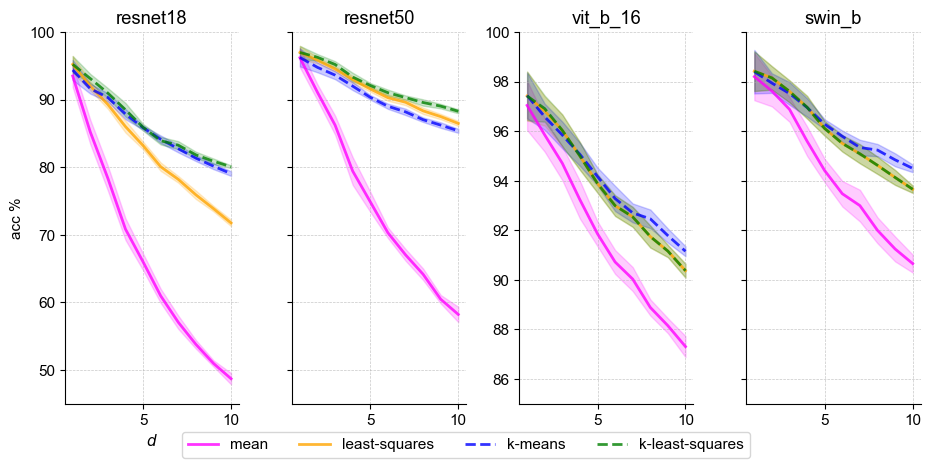

In [31]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from helper import GROUPPARAMS, HYPERPARAMS

# Filter and aggregate data
df_focus = df_loaded.copy()
for key, vals in focus_column_values.items():
	df_focus = df_focus[df_focus[key].isin(vals)]
df_focus = df_focus[
	((df_focus["proxy_method"] == "kmeans")
	& (df_focus["normalize_for_proxy_selection"].isin(focus_column_values_norms_kmeans["normalize_for_proxy_selection"]))
	& (df_focus["normalize_weights"].isin(focus_column_values_norms_kmeans["normalize_weights"]))
	& (df_focus["normalize_input_data"].isin(focus_column_values_norms_kmeans["normalize_input_data"])))
	| ((df_focus["proxy_method"] == "kls")
	& (df_focus["normalize_for_proxy_selection"].isin(focus_column_values_norms_kls["normalize_for_proxy_selection"]))
	& (df_focus["normalize_weights"].isin(focus_column_values_norms_kls["normalize_weights"]))
	& (df_focus["normalize_input_data"].isin(focus_column_values_norms_kls["normalize_input_data"])))
]

df_focus = (
	df_focus
	.groupby(GROUPPARAMS + HYPERPARAMS)
	.agg(
		median_task_acc=("task_acc", "median"),
		std=("task_acc", "std"),
		count=("seed", "count"),
	)
	.reset_index()
)

# Extract d from mapping_name for ImageNet and handle NaN values
df_focus["d"] = pd.to_numeric(df_focus["mapping_name"].str.extract(r"map(\d+)-")[0], errors='coerce').fillna(-1).astype(int)

# FIRST: Aggregate over the 10 remappings for each d
df_aggregated = (
	df_focus
	.groupby(["backbone_name", "d", "proxy_method", "k"] +
			 [col for col in HYPERPARAMS if col not in ["proxy_method", "k"]])
	.agg(
		mean_acc=("median_task_acc", "mean"),
		std_acc=("median_task_acc", "std"),
		count=("median_task_acc", "count"),
	)
	.reset_index()
)
df_aggregated["ci95"] = 1.96 * df_aggregated["std_acc"] / np.sqrt(df_aggregated["count"])

# THEN: Find best k for each (backbone, d, method) combination using aggregated data
best_k_results = []
df_adaptive = df_aggregated[df_aggregated["proxy_method"].isin(["kmeans", "kls"])]

for (bb, d, method), group in df_adaptive.groupby(["backbone_name", "d", "proxy_method"]):
	best_row = group.loc[group["mean_acc"].idxmax()]
	best_k_results.append(best_row)

df_best_k = pd.DataFrame(best_k_results)
# Print the optimal k values
# print("Optimal k values for each (backbone, d, method):")
# for _, row in df_best_k.iterrows():
	# print(f"Backbone: {row['backbone_name']}, d: {row['d']}, Method: {row['proxy_method']}, Optimal k: {row['k']}, Mean Acc: {row['mean_acc']:.2f} ± {1.96 * row['std_acc'] / np.sqrt(row['count']):.2f}")

# For k=1 methods (mean, ls), get their data from aggregated results
df_k1_methods = df_aggregated[df_aggregated["proxy_method"].isin(["kmeans", "kls"]) & (df_aggregated["k"] == 1)]
# Rename kls to ls and kmeans to mean in here
df_k1_methods["proxy_method"] = df_k1_methods["proxy_method"].replace({"kmeans": "mean", "kls": "ls"})


# Combine results
df_plot = pd.concat([df_k1_methods, df_best_k], ignore_index=True)

# Final dataframe is already aggregated, so use it directly
df_final = df_plot.copy()

# Plotting
backbones = ["resnet18", "resnet50", "vit_b_16", "swin_b"]
methods = ["mean", "ls", "kmeans", "kls"]
colors = {"mean": "magenta", "ls": "orange", "kmeans": "blue", "kls": "green"}
markers = {"mean": "o", "ls": "s", "kmeans": "^", "kls": "D"}
linestyles = {"mean": "-", "ls": "-", "kmeans": "--", "kls": "--"}

method_renamer = {
	"mean": "mean",
	"ls": "least-squares",
	"kmeans": "k-means",
	"kls": "k-least-squares",
}
aspect_ratio = 3 / 4
fig_height = text_width_inches * aspect_ratio
plt.rcParams.update({'font.size': 11})
fig, axes = plt.subplots(1, 4, sharey=False, figsize=(1.5*text_width_inches, fig_height))

for ax, bb in zip(axes, backbones):
	for method in methods:
		method_label = method_renamer[method]
		method_data = df_final[
			(df_final["backbone_name"] == bb) &
			(df_final["proxy_method"] == method)
		].sort_values("d")

		if not method_data.empty:
			ax.plot(
				method_data["d"],
				method_data["mean_acc"],
				color=colors[method],
				linestyle=linestyles[method],
				# marker=markers[method],
				label=method_label,
				linewidth=2,
				markersize=6,
				alpha=0.8,
			)
			ax.fill_between(
				method_data["d"],
				method_data["mean_acc"] - method_data["ci95"],
				method_data["mean_acc"] + method_data["ci95"],
				color=colors[method],
				alpha=0.2,
			)

			# Annotate best k for adaptive methods
			# if method in ["kmeans", "kls"]:
			#     for _, row in method_data.iterrows():
			#         if row["k"] > 1:  # Only annotate if k > 1
			#             ax.annotate(
			#                 f'k={int(row["k"])}',
			#                 (row["d"], row["mean_acc"]),
			#                 xytext=(5, 5),
			#                 textcoords='offset points',
			#                 fontsize=8,
			#                 color=colors[method],
			#                 alpha=0.8
			#             )

	ax.set_title(bb)
	if bb == backbones[0]:
		ax.set_xlabel(r"$d$")
		ax.set_ylabel("acc %")
	ax.spines["top"].set_visible(False)
	ax.spines["right"].set_visible(False)
	# ax.grid(True, alpha=0.3)
	ax.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

	if "resnet" in bb:
		ax.set_ylim(45, 100)
	else:
		ax.set_ylim(85, 100)

	if bb in ["resnet50", "swin_b"]:
		# Hide y-tick labels for these backbones
		ax.tick_params(labelleft=False)



# Add legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
	handles, labels,
	loc="lower center",
	ncol=len(methods),
	bbox_to_anchor=(0.5, 0),
	fontsize=11
)

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig(
    os.path.join(graphs_save_dict, "d_vs_accuracy_methods_comparison.pdf"),
    bbox_inches="tight",
    dpi=300
)
plt.savefig(
    os.path.join(graphs_save_dict, "d_vs_accuracy_methods_comparison.svg"),
    bbox_inches="tight",
    dpi=300
)
plt.show()

### Increase in using k>1 (e.g., k=5) vs. NC1 (Fig. 12)
Load preprocessed data (into `df_loaded`) and also NC1 data into `results_all` and `other` before.

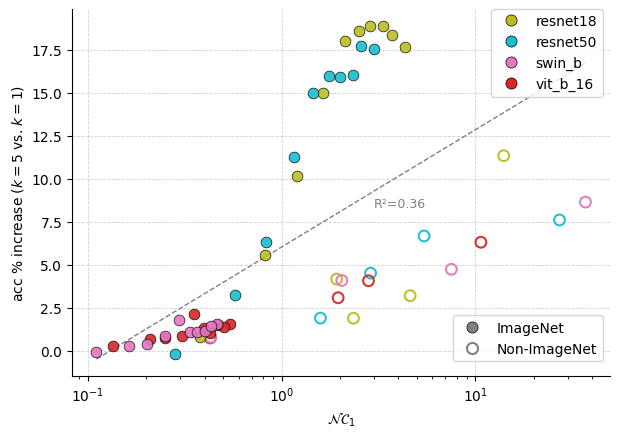

Correlation general: 0.2010
Correlation (nc1 < 1): 0.8723
Correlation (nc1 > 1): -0.1571
Correlation (nc1 > 1, ImageNet): 0.7567
Correlation (nc1 > 1, Non-ImageNet): 0.7069
any nc:
  Spearman Correlation: 0.8179
  Spearman p-value: 1.4240975922467733e-14
  R²: 0.3559
  Slope: 6.8186
nc1 < 1:
  Spearman Correlation: 0.7845
  Spearman p-value: 1.2784143225892393e-06
  R²: 0.5394
  Slope: 5.1697
nc1 > 1:
  Spearman Correlation: 0.0517
  Spearman p-value: 0.7898781073350564
  R²: 0.0243
  Slope: -2.6078
nc1 > 1 (ImageNet):
  Spearman Correlation: 0.8107
  Spearman p-value: 0.0002460079779722063
  R²: 0.7312
  Slope: 13.0837
nc1 > 1 (Non-ImageNet):
  Spearman Correlation: 0.0517
  Spearman p-value: 0.7898781073350564
  R²: 0.0243
  Slope: -2.6078


In [67]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import pandas as pd
import re
import numpy as np

graphs_save_dict = "result_graphs"
os.makedirs(graphs_save_dict, exist_ok=True)

# Rename nc dataframes
nc1_imagenet = results_all.copy()
nc1_non_imagenet = other.copy()

# Filter for specified hyperparameters
df = df_loaded[
    (df_loaded["task_name"] == "all")
    & (df_loaded["proxy_method"] == "kmeans")
    & (df_loaded["aggregation_method"] == "max")
    & (df_loaded["normalize_for_proxy_selection"] == "l2")
    & (df_loaded["normalize_weights"] == "l2")
    & (df_loaded["normalize_input_data"] == "l2")
    & (df_loaded["m"] == -1)
    & (df_loaded["seed"].isin([17121997, 123987, 12412312]))
].copy()

# Focus on certain columns of interest
df = df[["backbone_name", "dataset_name", "mapping_name", "seed", "k", "task_acc"]]

# Only keep k=1 and k=5 for comparison
df_k1 = df[df["k"] == 1]
df_k5 = df[df["k"] == 5]

# Merge
merge_cols = [
    "backbone_name",
    "dataset_name",
    "mapping_name",
    "seed",
]
merged = pd.merge(df_k1, df_k5, on=merge_cols, suffixes=("_k1", "_k5"))

# Compute accuracy increase
merged["acc_increase"] = merged["task_acc_k5"] - merged["task_acc_k1"]

# Compute normalized accuracy increase
merged["acc_increase_normalized"] = (
    merged["acc_increase"] / merged["task_acc_k1"]
) * 100

# Rename "combined" mapping (from CombiDigits) to "none"
merged["mapping_name"] = merged["mapping_name"].replace({"combined": "none"})


# Add a column to results_all with mapping_name format
def remapping_to_map(remapping):
    m = re.match(r"(\d+)_in_1-(\d+)", str(remapping))
    if m:
        return f"map{m.group(1)}-{m.group(2)}"
    return remapping  # fallback for other formats


nc1_imagenet["mapping_name"] = nc1_imagenet["remapping"].apply(remapping_to_map)
nc1_imagenet = nc1_imagenet[["backbone", "mapping_name", "nc_1"]].rename(
    columns={"backbone": "backbone_name"}
)
nc1_imagenet["dataset_name"] = "ImageNet"
nc1_non_imagenet["mapping_name"] = "none"
nc1_non_imagenet = nc1_non_imagenet[["backbone", "dataset", "mapping_name", "nc_1"]].rename(
    columns={"dataset": "dataset_name", "backbone": "backbone_name"}
)
# Merge NC1 values from nc1_imagenet and nc1_non_imagenet
merged_imagenet = pd.merge(
    merged[merged["dataset_name"] == "ImageNet"],
    nc1_imagenet,
    on=["backbone_name", "dataset_name", "mapping_name"],
    how="left",
)
merged_non_imagenent = pd.merge(
    merged[merged["dataset_name"] != "ImageNet"],
    nc1_non_imagenet,
    on=["backbone_name", "dataset_name", "mapping_name"],
    how="left",
)

merged = pd.concat([merged_imagenet, merged_non_imagenent])

# Step 1: Average acc_increase and nc_1 across seeds for each backbone/dataset/mapping
step1 = merged.groupby(["backbone_name", "dataset_name", "mapping_name"], as_index=False).agg(
    acc_increase_mean=("acc_increase", "mean"),
    acc_increase_std=("acc_increase", "std"),
    nc_1_mean=("nc_1", "mean"),
    nc_1_std=("nc_1", "std"),
)

# Step 2: Extract map group (e.g., map1, map2, ...) and average across mapX-0 ... mapX-9
step1["map_group"] = step1["mapping_name"].str.extract(r"(map\d+)-", expand=False)
# fill NaN map_group with the original mapping_name (e.g. "none", "combined", etc.)
step1["map_group"] = step1["map_group"].fillna(step1["mapping_name"])
# Now aggregate per backbone, dataset, and map_group (ImageNet map groups averaged across remaps;
# non-ImageNet rows like "none" remain as their own group)
step2 = step1.groupby(["backbone_name", "dataset_name", "map_group"], as_index=False).agg(
    acc_increase_mean=("acc_increase_mean", "mean"),
    acc_increase_std=("acc_increase_mean", "std"),
    nc_1_mean=("nc_1_mean", "mean"),
    nc_1_std=("nc_1_mean", "std"),
)

# Drop rows with NaN map_group (if any)
plot_df = step2.dropna(subset=["map_group"])

# Color by backbone only for ImageNet points
backbones = plot_df["backbone_name"].unique()
plot_df["color"] = plot_df["backbone_name"].map(backbone_colors)

# plotting
aspect_ratio = 3 / 4
fig_height = text_width_inches * aspect_ratio
plt.rcParams.update({"font.size": 10})  # Adjust size as needed
plt.figure(figsize=(text_width_inches, fig_height))
ax = plt.gca()

# Plot ImageNet (filled) and non-ImageNet (hollow) separately, per-backbone colors
s = 60
for bb, col in backbone_colors.items():
    subset_im = plot_df[(plot_df["backbone_name"] == bb) & (plot_df["dataset_name"] == "ImageNet")]
    subset_non = plot_df[(plot_df["backbone_name"] == bb) & (plot_df["dataset_name"] != "ImageNet")]

    if not subset_im.empty:
        ax.scatter(
            subset_im["nc_1_mean"],
            subset_im["acc_increase_mean"],
            color=col,
            edgecolors="k",
            linewidths=0.5,
            s=s,
            alpha=0.9,
            zorder=3,
        )
    if not subset_non.empty:
        ax.scatter(
            subset_non["nc_1_mean"],
            subset_non["acc_increase_mean"],
            facecolors="none",
            edgecolors=col,
            linewidths=1.5,
            s=s,
            alpha=0.95,
            zorder=2,
        )

# Cosmetics: gridlines, remove top/right spines
ax.grid(True, linestyle="--", linewidth=0.6, alpha=0.6)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
# Set xaxis scale to log
# ax.set_xscale("symlog",linthresh=1)
ax.set_xscale("log")
# ax.set_yscale("log")
# set xlim to 0-10
# ax.set_xlim(0,15)
ax.set_xlabel(r"$\mathcal{NC}_1$")
ax.set_ylabel(r"acc % increase ($k=5$ vs. $k=1$)")
# ax.set_title(
#     "Accuracy Gain vs NC1 (ImageNet, colored by backbone)\n(non-ImageNet NC1 shown as dotted outlines)"
# )

# Build two legends containing backbone (color) resp. dataset (style) entries
backbone_handles = []

# backbone handles (colored filled markers)
for bb in backbones:
    h = mlines.Line2D(
        [],
        [],
        color="w",
        marker="o",
        markerfacecolor=backbone_colors[bb],
        markeredgecolor="k",
        markersize=8,
        markeredgewidth=0.5,
        label=bb,
    )
    backbone_handles.append(h)

leg_backbones = ax.legend(
    backbone_handles,
    [h.get_label() for h in backbone_handles],
    loc="upper right",
    bbox_to_anchor=(1.0, 1.02),
    fontsize=10,
)
ax.add_artist(leg_backbones)

# dataset-style handles (filled vs hollow)
h_im = mlines.Line2D(
    [],
    [],
    color="w",
    marker="o",
    markerfacecolor="gray",
    markeredgecolor="k",
    markeredgewidth=0.5,
    markersize=8,
    label="ImageNet",
)
h_non = mlines.Line2D(
    [],
    [],
    color="w",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="gray",
    markeredgewidth=1.5,
    markersize=8,
    label="Non-ImageNet",
)

# ax.axvline(1, color="black", linestyle="--", linewidth=1)

# Example: Fit and plot separate regression lines
subset_nc1_lt_1 = plot_df[plot_df["nc_1_mean"] < 1]
subset_nc1_gt_1 = plot_df[plot_df["nc_1_mean"] > 1]
subset_nc1_gt_1_imagenet = plot_df[(plot_df["nc_1_mean"] > 1) & (subset_nc1_gt_1["dataset_name"] == "ImageNet")]
subset_nc1_gt_1_non_imagenet = plot_df[(plot_df["nc_1_mean"] > 1) & (subset_nc1_gt_1["dataset_name"] != "ImageNet")]

# Fit and plot separate regression lines for nc1 > 1 (ImageNet and Non-ImageNet)
for subset, label, linestyle in [
    (plot_df, "nc1 all", "--")
    # (subset_nc1_lt_1, "nc1 < 1", "solid"),
    # (subset_nc1_gt_1, "nc1 > 1", "solid"),
    # (subset_nc1_gt_1_imagenet, "nc1 > 1 (ImageNet)", "dashed"),
    # (subset_nc1_gt_1_non_imagenet, "nc1 > 1 (Non-ImageNet)", "dashed"),
]:
    X = np.log10(subset["nc_1_mean"].values).reshape(-1, 1)  # Log-transform x-values
    # X = subset["nc_1_mean"].values.reshape(-1, 1)
    y = subset["acc_increase_mean"].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)  # Compute R² value
    slope = model.coef_[0]

    # Plot the regression line on the original scale
    xs_plot = np.logspace(
		np.log10(plot_df["nc_1_mean"].min()),
		np.log10(plot_df["nc_1_mean"].max()),
		num=100  # Number of points in the grid
	).reshape(-1, 1)
    ys_plot = model.predict(np.log10(xs_plot))
    ax.plot(
        xs_plot,
        ys_plot,
        linestyle=linestyle,
        linewidth=1,
        color="gray",  # Make all regression lines black
    )

    # Annotate R² value at the line
    draw_pos_x = 3  # NC1 value
    # max_x = min(15,subset["nc_1_mean"].max())
    draw_pos_y = model.predict([[np.log10(draw_pos_x)]])[0]  # Corresponding y-value

    ax.text(
        draw_pos_x,
        draw_pos_y-0.75,
        f"R²={r2:.2f}", #, slope={slope:.2f}",
        fontsize=9,
        color="gray",
        ha="left",
        va="center",
    )

ax.legend(
    [h_im, h_non],
    ["ImageNet", "Non-ImageNet"],
    loc="lower right", ncol=1,  fontsize=10,     bbox_to_anchor=(1.0, 0.02),
)
plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.savefig(os.path.join(graphs_save_dict, f"acc_inc_vs_nc1.pdf"), bbox_inches="tight", dpi=300)
plt.savefig(os.path.join(graphs_save_dict, f"acc_inc_vs_nc1.png"), bbox_inches="tight", dpi=300)
plt.show()

# Compute correlations
# 1. All points with nc1 < 1
subset_nc1_lt_1 = plot_df[plot_df["nc_1_mean"] < 1]
correlation_nc1_lt_1 = subset_nc1_lt_1["nc_1_mean"].corr(subset_nc1_lt_1["acc_increase_mean"])

# 2. All points with nc1 > 1
subset_nc1_gt_1 = plot_df[plot_df["nc_1_mean"] > 1]
correlation_nc1_gt_1 = subset_nc1_gt_1["nc_1_mean"].corr(subset_nc1_gt_1["acc_increase_mean"])

# 3. Points with nc1 > 1 and dataset == "ImageNet"
subset_nc1_gt_1_imagenet = subset_nc1_gt_1[subset_nc1_gt_1["dataset_name"] == "ImageNet"]
correlation_nc1_gt_1_imagenet = subset_nc1_gt_1_imagenet["nc_1_mean"].corr(
    subset_nc1_gt_1_imagenet["acc_increase_mean"]
)

# 4. Points with nc1 > 1 and dataset != "ImageNet"
subset_nc1_gt_1_non_imagenet = subset_nc1_gt_1[subset_nc1_gt_1["dataset_name"] != "ImageNet"]
correlation_nc1_gt_1_non_imagenet = subset_nc1_gt_1_non_imagenet["nc_1_mean"].corr(
    subset_nc1_gt_1_non_imagenet["acc_increase_mean"]
)

# 5. All points
correlation_general = plot_df["nc_1_mean"].corr(plot_df["acc_increase_mean"])

# Print results
print(f"Correlation general: {correlation_general:.4f}")
print(f"Correlation (nc1 < 1): {correlation_nc1_lt_1:.4f}")
print(f"Correlation (nc1 > 1): {correlation_nc1_gt_1:.4f}")
print(f"Correlation (nc1 > 1, ImageNet): {correlation_nc1_gt_1_imagenet:.4f}")
print(f"Correlation (nc1 > 1, Non-ImageNet): {correlation_nc1_gt_1_non_imagenet:.4f}")


from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Function to compute Spearman, R², and slope for a given subset
def compute_spearman_r2_slope(subset, x_col, y_col):
    if subset.empty:
        return None, None, None
    log_x = np.log10(subset[x_col].values)
    # Spearman's rank correlation
    spearman_corr, p_val = spearmanr(log_x, subset[y_col])

    # R² (coefficient of determination) and slope
    X =  log_x.reshape(-1, 1)
    y = subset[y_col].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    slope = model.coef_[0]  # Slope of the regression line

    return spearman_corr, p_val, r2, slope

# Compute for each region
regions = {
	"any nc": plot_df,
    "nc1 < 1": plot_df[plot_df["nc_1_mean"] < 1],
    "nc1 > 1": plot_df[plot_df["nc_1_mean"] > 1],
    "nc1 > 1 (ImageNet)": plot_df[(plot_df["nc_1_mean"] > 1) & (plot_df["dataset_name"] == "ImageNet")],
    "nc1 > 1 (Non-ImageNet)": plot_df[(plot_df["nc_1_mean"] > 1) & (plot_df["dataset_name"] != "Non-ImageNet")],
}

results = {}
for region_name, subset in regions.items():
    spearman_corr, p_val, r2, slope = compute_spearman_r2_slope(subset, "nc_1_mean", "acc_increase_mean")
    results[region_name] = {"Spearman": spearman_corr, "p_val": p_val, "R²": r2, "Slope": slope}

# Print results
for region, metrics in results.items():
    print(f"{region}:")
    print(f"  Spearman Correlation: {metrics['Spearman']:.4f}")
    print(f"  Spearman p-value: {metrics['p_val']}")
    print(f"  R²: {metrics['R²']:.4f}")
    print(f"  Slope: {metrics['Slope']:.4f}")

### tSNE for CombiDigits embeddings

All the embeddings are in imprinting-reproduce/embeddings.


In [12]:
from src.experiments.runner import get_data
from torch.utils.data import DataLoader

size, embeddings_train, embeddings_test = get_data(
    backbone_name="resnet18",
    dataset_name=["MNIST", "MNIST-M", "SVHN", "USPS"],
    data_dir="../imprinting-reproduce",
    label_mapping={i + j * 10: i for i in range(10) for j in range(4)},
)
embeddings, labels = next(iter(DataLoader(embeddings_train, batch_size=len(embeddings_train))))

# For finding out from which dataset it came, I also need to remember

/Users/jw/Documents/multi-imprinting/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Run TSNE on embeddings
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

X = embeddings.cpu().numpy()
y = labels.cpu().numpy()
# Use embeddings_train.cumulative_sizes to get origin
cumsizes = embeddings_train.cumulative_sizes
origin = torch.tensor(list(range(len(labels))), dtype=torch.int64)
origin[origin < cumsizes[0]] = 0
origin[(origin >= cumsizes[0]) & (origin < cumsizes[1])] = 1
origin[(origin >= cumsizes[1]) & (origin < cumsizes[2])] = 2
origin[origin >= cumsizes[2]] = 3
origin = origin.tolist()
# Replace 0 in this list by MNIST, 1 by MNIST-M etc.
origin = [
    "MNIST" if o == 0 else "MNIST-M" if o == 1 else "SVHN" if o == 2 else "USPS" for o in origin
]
n_sample = 10_000
indices = np.random.choice(len(X), n_sample, replace=False)
X_sample = X[indices]
y_sample = y[indices]

In [4]:
# tsne_all = TSNE(n_components=2, random_state=42)
# X_tsne_all = tsne_all.fit_transform(X_sample)


# # Plot t-SNE for all classes
# plt.figure(figsize=(10, 8))
# scatter = plt.scatter(X_tsne_all[:, 0], X_tsne_all[:, 1], c=y_sample, cmap="tab10", alpha=0.6)
# plt.colorbar(scatter)
# plt.title("t-SNE of Embeddings - All Classes")
# plt.xlabel("t-SNE 1")
# plt.ylabel("t-SNE 2")
# plt.show()

# print(f"Unique classes: {np.unique(y)}")

# -> Not really meaningful

Class 6 has 10000 samples


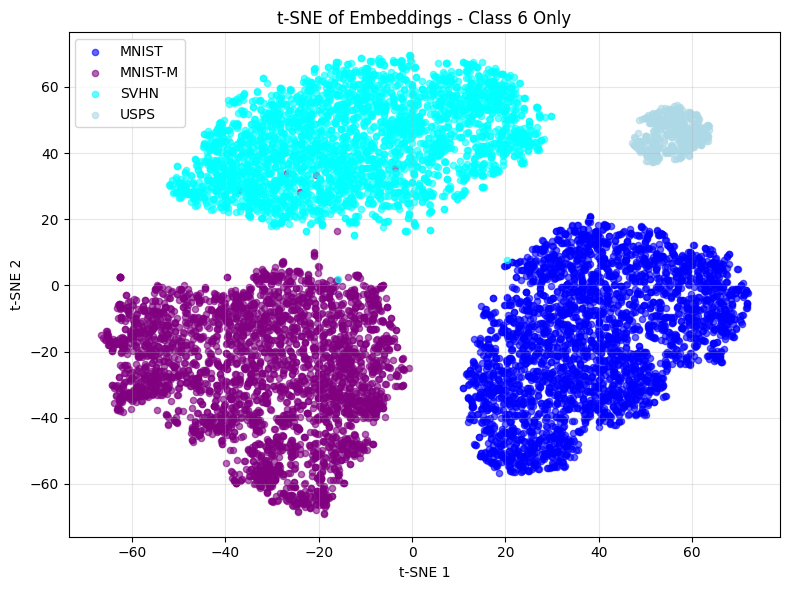

In [ ]:
# Filter for class 6 only
class_6_mask = y == 6
X_class6 = X[class_6_mask]
y_class6 = y[class_6_mask]
origin_array = np.array(origin)
origin_class6 = origin_array[class_6_mask]
# Samples
n_sample = 10_000
indices = np.random.choice(len(X_class6), n_sample, replace=False)
X_class6_sample = X_class6[indices]
y_class6_sample = y_class6[indices]
origin_class6_sample = [origin_class6[i] for i in indices]

print(f"Class 6 has {X_class6_sample.shape[0]} samples")

# Run t-SNE on class 6 embeddings only
tsne_class6 = TSNE(n_components=2, random_state=42)
X_tsne_class6 = tsne_class6.fit_transform(X_class6_sample)

# Define color mapping
color_map = {"MNIST": "blue", "MNIST-M": "purple", "SVHN": "cyan", "USPS": "lightblue"}

# Create colors array
colors = [color_map[dataset] for dataset in origin_class6_sample]

# Plot t-SNE for class 6
plt.figure(figsize=(8, 6))

# Plot each dataset separately to create legend
for dataset in color_map.keys():
    mask = np.array(origin_class6_sample) == dataset
    if np.any(mask):
        plt.scatter(
            X_tsne_class6[mask, 0],
            X_tsne_class6[mask, 1],
            c=color_map[dataset],
            alpha=0.6,
            label=dataset,
            s=20,
        )

plt.title("t-SNE of Embeddings - Class 6 Only")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
# UMAP is much faster for large datasets
import umap
import umap.plot

# mapper = umap.UMAP(random_state=42).fit_transform(X_class6_sample)
# umap.plot.points(mapper, labels=y_class6_sample)
# -> doesn't work for some reason..